# Sentiment Analysis

## Bidirectional GRU/LSTM with Attention

In this notebook I provide the best performing stacked bidirectional GRU and LSTMs with Gradient Clipping, Dropout Probability and Attention. I mainly used early stopping to avoid overfitting, but later on I decreased the batch size to be able to run on the GPU (a larger batch size created too large matrices for the allowed Kaggle RAM limit) so even after one or two epochs the network was trained adequately.

### Libraries & Dataset

To pack the sequences easily I'll be using the legacy version of torchtext which provides some functionality that has been removed from later versions. So you first need to install the specific version below. (It might conflict with some packages, but I won't be using these.)


In [1]:
!pip install -U torchtext==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 4.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 1.6 MB/s eta 0:00:0000:0100:02
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.7.7 requires torch>=1.9.*, but you have torch 1.8.0 which is incompatible.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.8.0 which is incompatible.


Then import the necessary libraries.

In [115]:
# Math, String, etc
import sys
import re
import os
import string
import time
import datetime
import random
import math

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import torchtext

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn

# Testing and metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

For reproducibility I'll define the seeding function.

In [3]:
def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

#### Network Training

I'll use the functions below to automate the training.

- The function `trainEpoch` trains a Neural Network for one epoch and calculates the loss for each batch and informs the weights. With the display boolean as true it also prints the loss with a rate of your choosing.

- Then `trainNetwork` simply trains a network till a number of epochs is reached and returns the model. Both functions take as arguments the optimizer, dataloader, loss function and device in case the GPU is used.

- The `evaluationFunction` passes the batches of the dataloader in the arguments through the model making predictions without informing the weights. It calculates and returns precision, recall and F1 macro averaged score, as well as the accuracy and mean loss.

In [5]:
DEVICE='cuda'
torch.cuda.is_available()

True

In [187]:
# Function to train for one epoch
def trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display=True, clip_value = 0.6):

    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        x, x_lengths = data.review
        y = data.rating
        
        # Predict and calculate loss
        prediction = neuralnetwork(x, x_lengths)
        loss = lossfunc(prediction, y)
        losses.append(loss.item())

        # Inform the weights
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradients
        nn.utils.clip_grad_norm_(neuralnetwork.parameters(), clip_value)
        optimizer.step()
        
        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(x)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    meanloss = 0
    if len(losses)!=0:
        # The total mean loss
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a network
def trainNetwork(epochs, optimizer, dataloader, lossfunc, neuralnetwork, device, display=True, clip_value = 0.6):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the neural network
    return neuralnetwork

# Evaluation function
def evaluationFunction(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():
        
        for batch, data in enumerate(dataloader):
            
            x, x_lengths = data.review
            y = data.rating

            # Make predictions
            scores = model(x, x_lengths)
            _, predictions = scores.max(1)

            # Probability estimates of the positive class
            y_probs = torch.sigmoid(scores[:,1]).cpu()
            
            # Loss
            loss = lossfunc(scores, y).item()
            losses.append(loss)

            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            y=y.cpu()
            probs.extend(y_probs.numpy())
            preds.extend(predictions.numpy())
            trues.extend(y.numpy())
            correctCount += (predictions==y).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(torch.tensor(trues),torch.tensor(preds), average="macro").item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =["negative", "positive"]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    seaborn.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.style.use('seaborn')
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

# Training till loss stops improving for patience
def earlyStop(device, model, display, epochs, traindataloader, valdataloader, lr, opti, lossfunc, patience, clip_value = 0.6):

    stopepoch=0
    countStop=0
    bestMeanloss= sys.float_info.max
    optimizer = opti(model.parameters(), lr = lr , weight_decay=1e-6)
    scheduler=lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.4, patience=1, verbose=False)

    # For each epoch
    for epoch in range(epochs):

        # If iterations are equal to patience
        if countStop==patience:
            print("Early stopping on epoch: ", epoch)
            stopepoch=epoch
            break

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display, clip_value = 0.6)
        _, _, _, meanlossval, accura, macrof1, recall, precision =  evaluationFunction(valdataloader, model, lossfunc, device, display)

        # If mean loss is less than the best so far
        if bestMeanloss>meanlossval:
            countStop=0
            bestMeanloss=meanlossval
        else:
            countStop+=1
        
        scheduler.step(meanLoss)    

    return model, stopepoch

# Function automating finding best model
def optimalModel(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False,clip_value = 0.6):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display, clip_value)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, recall, precision = evaluationFunction(valdataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " validation loss: ", meanlossval, " and accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestModel.pt')
            torch.save(optimizer.state_dict(), './bestOptimizer.pt')
    
        if(display):
            print("__________________________________")

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.style.use('seaborn')
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch

### Tokenizer and GloVe Embeddings

Initially processing the data to only contain the review and rating and also changing the rating to be either 1 or 0, ie positive or negative.

In [8]:
df = pd.read_csv("/kaggle/input/imdbreviews/imdb-reviews.csv", sep = '\t')
df.columns = ['url', 'rating', 'review']
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

frames = [X, Y]
conc = pd.concat(frames, axis=1)
conc.to_csv('proper_data.csv', index=None)
df = pd.read_csv('proper_data.csv')
df.head()

,review,rating
0,I thought this was a quiet good movie. It was ...,1.0
1,Wagon Master is a very unique film amongst Joh...,1.0
2,This film has to be as near to perfect a film ...,1.0
3,I gave this 4 stars because it has a lot of in...,0.0
4,This movie is really genuine and random. It's ...,1.0


Split Dataset into Train/Validation/Test Process the dataset. I initially only used 40% of the dataset provided to be able to run more experiments.

In [9]:
# Field and Label Field for review and sentiment
REVIEW = torchtext.legacy.data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm', include_lengths=True)
SENTIMENT = torchtext.legacy.data.LabelField(dtype=torch.long)
fields = [('review', REVIEW), ('rating', SENTIMENT)]
dataset = torchtext.legacy.data.TabularDataset(path='/kaggle/working/proper_data.csv', format='csv', skip_header=True, fields=fields)
dataset, unused = dataset.split(split_ratio=[0.4, 0.6])
train_dataset, test_dataset = dataset.split(split_ratio=[0.8, 0.2])
train_dataset, val_dataset = train_dataset.split(split_ratio=[0.85, 0.15])

Build the vocabulary and the dataloaders.

In [40]:
DEVICE = 'cuda'
VOCAB_SIZE = 10000
BATCH_SIZE = 32
REVIEW.build_vocab(train_dataset, max_size=VOCAB_SIZE, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
SENTIMENT.build_vocab(train_dataset)
train_dataloader, val_dataloader, test_dataloader = torchtext.legacy.data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=BATCH_SIZE, sort_within_batch=True, sort_key=lambda x: len(x.review), device=DEVICE)

### GRU Training & Evaluation

I'll initially define the simple one layer GRU network I defined in the previous notebook this time using the pack padded sequence function then that packs a Tensor containing [padded sequences](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) of variable length. The answers in this [post](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) were also helpful by displaying how this method works and how to create the network. The difference is that I need to pass the lengths of the reviews as well.

In [19]:
class GRU(torch.nn.Module):
    
    def __init__(self, input, embedding, hidden, output):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(embedding, hidden)        
        self.linear = torch.nn.Linear(hidden, output)

    def forward(self, X, X_length):
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = h_0.squeeze_(0)
        output = self.linear(h_0)
        return output

Training the network for 8 epochs.

Epoch 1
__________________________________
loss: 0.699133  [    0/12242]

Evaluation Results
_________________________________
Predicted 1309 / 2160 correctly
Mean Loss: 0.66 
Recall: 66.00%
Precision: 58.62%
Accuracy: 60.60%
Macro Averaged F1-score: 60.54%
_________________________________
Training loss:  0.6953109974662463  validation loss:  0.662584412097931  and accuracy:  60.60185185185185
__________________________________
Epoch 2
__________________________________
loss: 0.627313  [    0/12242]

Evaluation Results
_________________________________
Predicted 1552 / 2160 correctly
Mean Loss: 0.56 
Recall: 70.55%
Precision: 71.50%
Accuracy: 71.85%
Macro Averaged F1-score: 71.83%
_________________________________
Training loss:  0.5973573476076126  validation loss:  0.558885133266449  and accuracy:  71.85185185185186
__________________________________
Epoch 3
__________________________________
loss: 0.510167  [    0/12242]

Evaluation Results
_________________________________
Predict

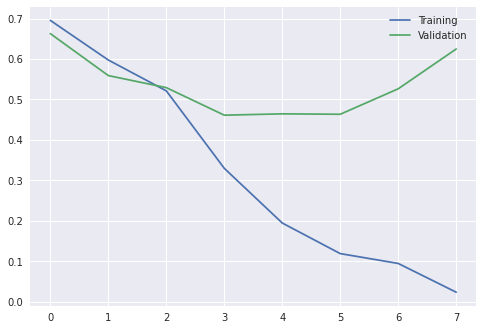

Best F1 score after  7  epochs.
Training Time: 0.40 minutes


In [20]:
LR = 0.005
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 256
CLASSES = 2

seedTorch()
model = GRU(INPUT, EMBEDDING, HIDDEN,CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

There is a bit of overfitting after the third epoch, but that's to be expected with that small batch size. Then I'll evaluate the model on the test data.


Evaluation Results
_________________________________
Predicted 3086 / 3601 correctly
Mean Loss: 0.53 
Recall: 83.16%
Precision: 87.32%
Accuracy: 85.70%
Macro Averaged F1-score: 85.68%
_________________________________


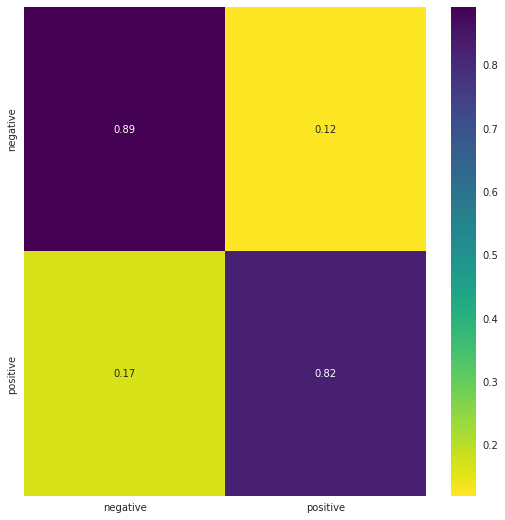

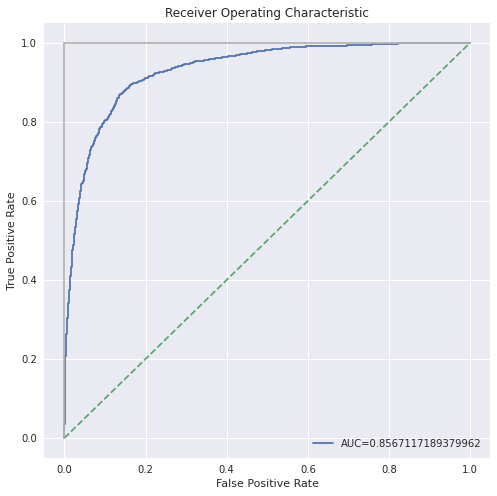

In [21]:
seedTorch()
model = GRU(INPUT, EMBEDDING, HIDDEN, CLASSES).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The model performs already very well without any tuning with scores around 85% across all metrics. Then I'll extend the GRU network below by passing the layers number as well to experiment with stacked GRUs as well as making it bidirectional.

In [61]:
class GRU_02(torch.nn.Module):
    
    def __init__(self, input, embedding, hidden, layers, output):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)        
        self.linear = torch.nn.Linear(hidden*layers, output)

    def forward(self, X, X_length):
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        output = self.linear(h_0)
        return output

I'll try a training of five epochs with two stacked GRU layers and a learning rate of 0.005 and hidden size of 64. These values were found after experimenting locally with Optuna as shown in the first notebook, since they were too time intensive to be trialed online on the limited GPU allocated on a free account.

Epoch 1
__________________________________
loss: 0.710301  [    0/12242]
loss: 0.671161  [13120/12242]
loss: 0.534028  [36992/12242]
loss: 0.565795  [46464/12242]
loss: 0.310578  [42752/12242]
loss: 0.402407  [52800/12242]

Evaluation Results
_________________________________
Predicted 1891 / 2160 correctly
Mean Loss: 0.30 
Recall: 85.70%
Precision: 88.47%
Accuracy: 87.55%
Macro Averaged F1-score: 87.53%
_________________________________
Training loss:  0.5201171756802278  validation loss:  0.3046829521875171  and accuracy:  87.5462962962963
__________________________________
Epoch 2
__________________________________
loss: 0.171140  [    0/12242]
loss: 0.186535  [10176/12242]
loss: 0.291257  [19072/12242]
loss: 0.258616  [38208/12242]
loss: 0.284464  [41984/12242]
loss: 0.264004  [65600/12242]

Evaluation Results
_________________________________
Predicted 1857 / 2160 correctly
Mean Loss: 0.32 
Recall: 94.03%
Precision: 80.54%
Accuracy: 85.97%
Macro Averaged F1-score: 85.92%
_________

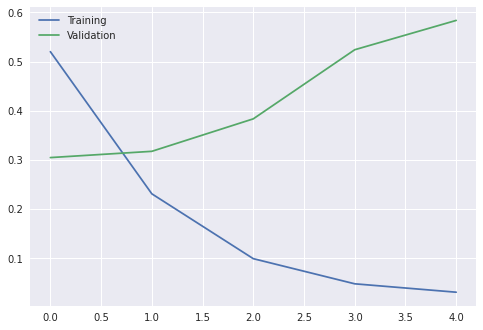

Best F1 score after  2  epochs.
Training Time: 1.25 minutes

Evaluation Results
_________________________________
Predicted 3170 / 3601 correctly
Mean Loss: 0.37 
Recall: 87.82%
Precision: 87.96%
Accuracy: 88.03%
Macro Averaged F1-score: 88.03%
_________________________________


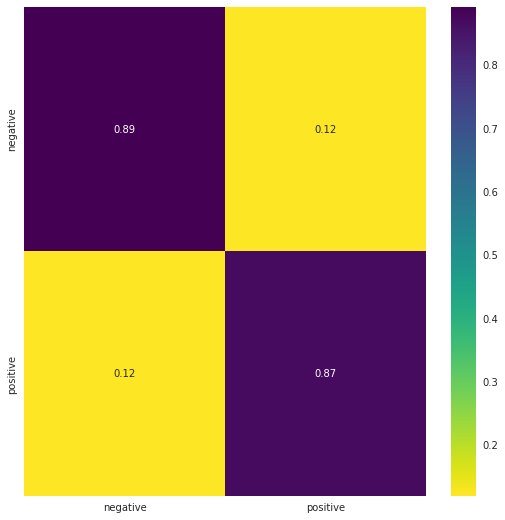

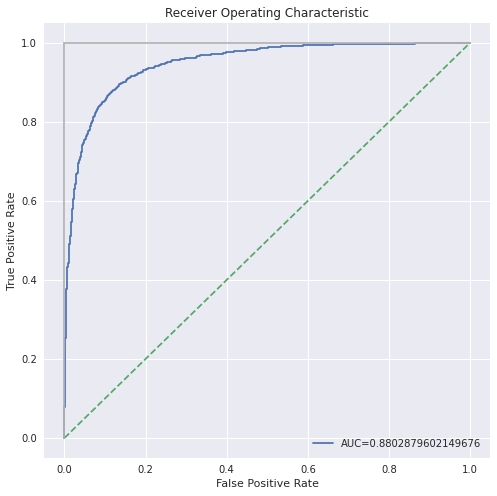

In [63]:
LR = 0.005
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 64
LAYERS = 2
CLASSES = 2

seedTorch()
model = GRU_02(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_02(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

With the stacked bidirectional GRU network there is even better performance across all metrics and the ROC curve looks really healthy as confirmed by the ROC auc score as well. Before trying in the LSTM network these techniques I'll incorporate Attention into the network. 

### Attention

Initially I'll extend the GRU network with a simplified version of an attention layer which is applied to the hidden states that are produced by the last GRU layer and then is passed to the linear layer. The attention layer computes a weighted sum of the hidden states that is passed through the linear layer to produce the final output.

In [92]:
class GRU_03(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.attention = torch.nn.Linear(hidden*2, 1)
        self.linear = torch.nn.Linear(hidden*2, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        attention = F.softmax(self.attention(h_0), dim=1)
        h_0 = h_0 * attention
        output = self.linear(h_0)
        return output

Then training the network with one layer.

Epoch 1
__________________________________
loss: 0.694218  [    0/12242]
loss: 0.743928  [51712/12242]
loss: 0.592577  [17920/12242]
loss: 0.556711  [33984/12242]
loss: 0.460481  [51200/12242]
loss: 0.441484  [89920/12242]

Evaluation Results
_________________________________
Predicted 1823 / 2160 correctly
Mean Loss: 0.38 
Recall: 87.78%
Precision: 81.67%
Accuracy: 84.40%
Macro Averaged F1-score: 84.39%
_________________________________
Training loss:  0.5609599086930173  validation loss:  0.3817792681648451  and accuracy:  84.39814814814814
__________________________________
Epoch 2
__________________________________
loss: 0.201115  [    0/12242]
loss: 0.244123  [29760/12242]
loss: 0.151877  [19712/12242]
loss: 0.211778  [66432/12242]
loss: 0.325158  [35840/12242]
loss: 0.140268  [83840/12242]

Evaluation Results
_________________________________
Predicted 1858 / 2160 correctly
Mean Loss: 0.35 
Recall: 93.47%
Precision: 80.90%
Accuracy: 86.02%
Macro Averaged F1-score: 85.98%
________

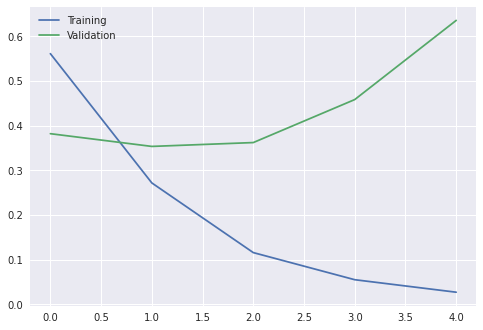

Best F1 score after  3  epochs.
Training Time: 0.73 minutes

Evaluation Results
_________________________________
Predicted 3137 / 3601 correctly
Mean Loss: 0.50 
Recall: 84.00%
Precision: 89.31%
Accuracy: 87.11%
Macro Averaged F1-score: 87.09%
_________________________________


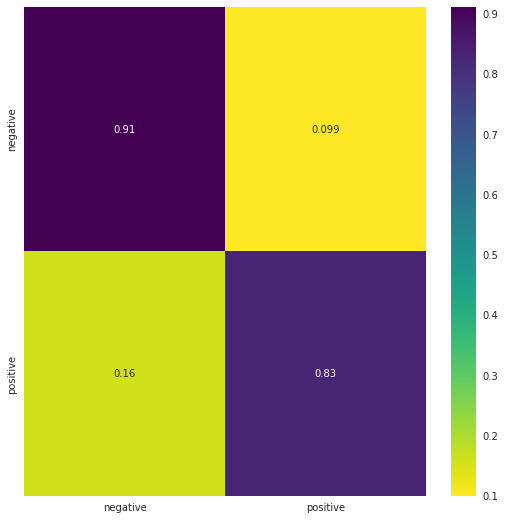

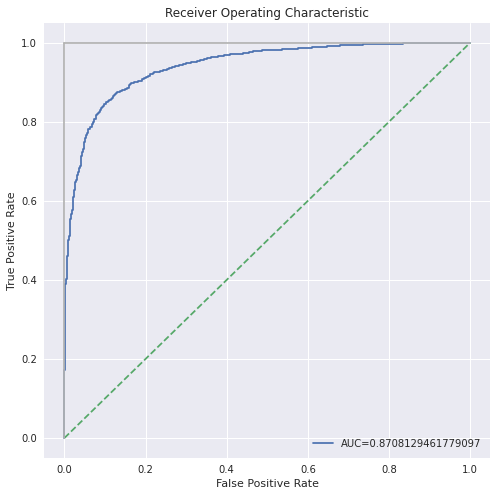

In [93]:
LR = 0.005
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 64
LAYERS = 1
CLASSES = 2

seedTorch()
model = GRU_03(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_03(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

With attention it performs better than the single layer GRU so I'll test on the two layers below as well.

Epoch 1
__________________________________
loss: 0.698819  [    0/12242]
loss: 0.670352  [12608/12242]
loss: 0.587974  [43904/12242]
loss: 0.367458  [28992/12242]
loss: 0.322466  [54272/12242]
loss: 0.520582  [96320/12242]

Evaluation Results
_________________________________
Predicted 1851 / 2160 correctly
Mean Loss: 0.33 
Recall: 79.26%
Precision: 90.29%
Accuracy: 85.69%
Macro Averaged F1-score: 85.60%
_________________________________
Training loss:  0.5094316298672176  validation loss:  0.32988814658978405  and accuracy:  85.69444444444444
__________________________________
Epoch 2
__________________________________
loss: 0.166393  [    0/12242]
loss: 0.395443  [ 7104/12242]
loss: 0.109597  [23808/12242]
loss: 0.203033  [27456/12242]
loss: 0.042294  [43776/12242]
loss: 0.132502  [85120/12242]

Evaluation Results
_________________________________
Predicted 1839 / 2160 correctly
Mean Loss: 0.37 
Recall: 93.75%
Precision: 79.52%
Accuracy: 85.14%
Macro Averaged F1-score: 85.08%
_______

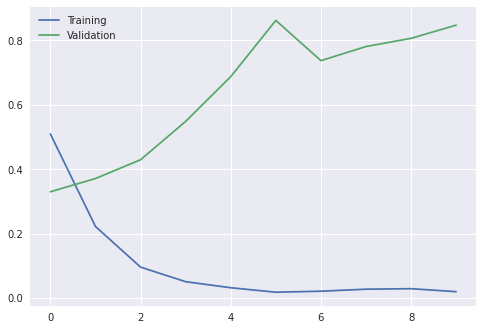

Best F1 score after  4  epochs.
Training Time: 2.60 minutes

Evaluation Results
_________________________________
Predicted 3170 / 3601 correctly
Mean Loss: 0.61 
Recall: 87.65%
Precision: 88.09%
Accuracy: 88.03%
Macro Averaged F1-score: 88.03%
_________________________________


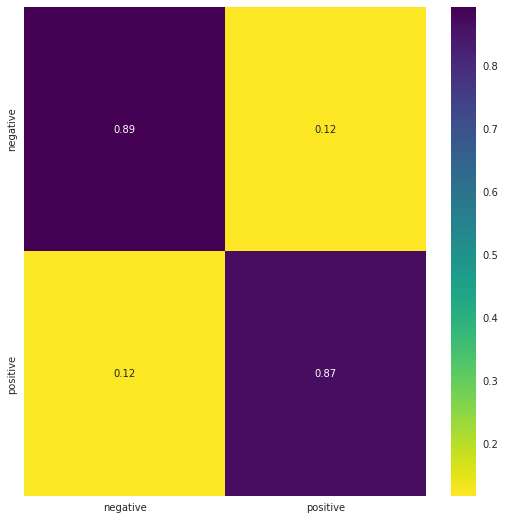

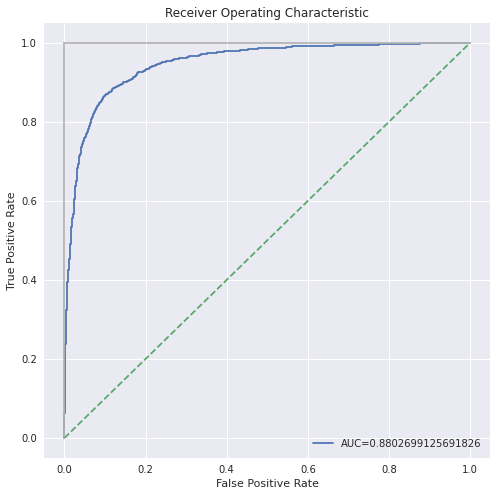

In [94]:
LR = 0.005
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 64
LAYERS = 2
CLASSES = 2

seedTorch()
model = GRU_03(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_03(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This has a similar performance so I'll be moving on to multi-headed attention.

### Multiheaded Attention

To implement multiheaded attention in this model, I modified the attention layer to perform multiple attention calculations using different linear projections with a ModuleList of linear layers that perform the different attention calculations. Then I modified the forward method to loop over the attention heads and compute the attention outputs. I then concatenated the attention outputs along the hidden size dimension to produce the final weighted sum as we saw in the suggested bibliography of the course's notes.

In [104]:
class GRU_04(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        
        # Perform multiple attention calculations using different linear projections
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        # Concatenate the attention along the hidden size dimension
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output


Then training the network for eighteen epochs to see if it requires more time with two layers and four heads.

Epoch 1
__________________________________
loss: 0.704349  [    0/12242]
loss: 0.693716  [21888/12242]
loss: 0.591048  [13440/12242]
loss: 0.493810  [40512/12242]
loss: 0.471630  [51968/12242]
loss: 0.596844  [213120/12242]

Evaluation Results
_________________________________
Predicted 1732 / 2160 correctly
Mean Loss: 0.45 
Recall: 64.77%
Precision: 92.43%
Accuracy: 80.19%
Macro Averaged F1-score: 79.61%
_________________________________
Training loss:  0.5584251128584535  validation loss:  0.45320701160851645  and accuracy:  80.18518518518518
__________________________________
Epoch 2
__________________________________
loss: 0.282224  [    0/12242]
loss: 0.351517  [11648/12242]
loss: 0.946088  [223104/12242]
loss: 0.105146  [75264/12242]
loss: 0.301194  [68096/12242]
loss: 0.243014  [76800/12242]

Evaluation Results
_________________________________
Predicted 1923 / 2160 correctly
Mean Loss: 0.28 
Recall: 87.88%
Precision: 89.49%
Accuracy: 89.03%
Macro Averaged F1-score: 89.02%
_____

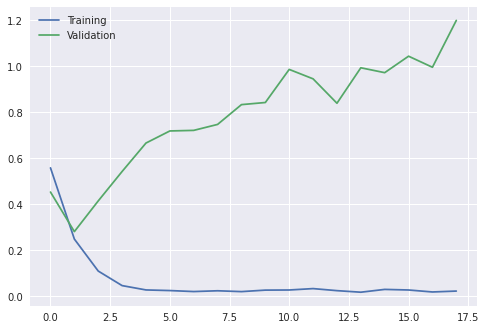

Best F1 score after  1  epochs.
Training Time: 5.21 minutes

Evaluation Results
_________________________________
Predicted 3196 / 3601 correctly
Mean Loss: 0.27 
Recall: 88.32%
Precision: 88.87%
Accuracy: 88.75%
Macro Averaged F1-score: 88.75%
_________________________________


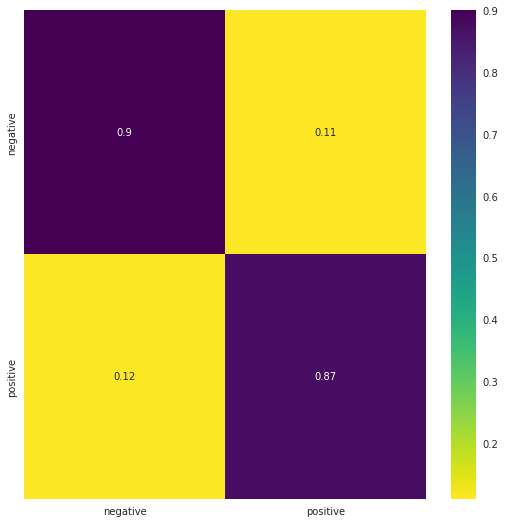

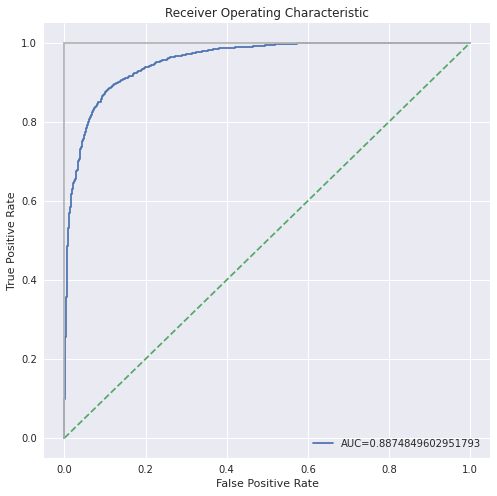

In [107]:
LR = 0.005
EPOCHS = 18
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 30
LAYERS = 2
HEADS = 4
CLASSES = 2

seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

That the model is overfitting as can be seen from the learning curve plot is not worrying since the test set is evaluated on the best model which was after 1 epoch. 

### Heads Experiments

Then testing the same network with two heads.

Epoch 1
__________________________________
loss: 0.719757  [    0/12242]
loss: 0.626543  [ 8192/12242]
loss: 0.606585  [16384/12242]
loss: 0.528014  [26880/12242]
loss: 0.327498  [75520/12242]
loss: 0.481793  [84480/12242]

Evaluation Results
_________________________________
Predicted 1828 / 2160 correctly
Mean Loss: 0.34 
Recall: 78.31%
Precision: 88.92%
Accuracy: 84.63%
Macro Averaged F1-score: 84.53%
_________________________________
Training loss:  0.5273046539245324  validation loss:  0.33940450496533336  and accuracy:  84.62962962962963
__________________________________
Epoch 2
__________________________________
loss: 0.227449  [    0/12242]
loss: 0.199305  [11008/12242]
loss: 0.191124  [24064/12242]
loss: 0.305144  [79680/12242]
loss: 0.187637  [64512/12242]
loss: 0.311188  [43520/12242]

Evaluation Results
_________________________________
Predicted 1886 / 2160 correctly
Mean Loss: 0.31 
Recall: 83.43%
Precision: 89.90%
Accuracy: 87.31%
Macro Averaged F1-score: 87.27%
_______

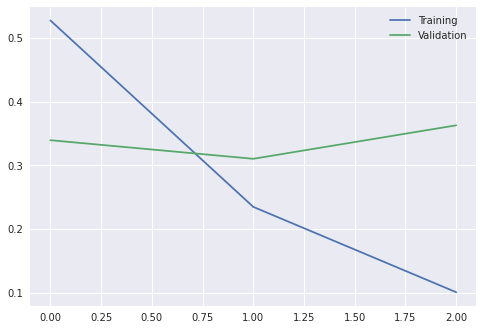

Best F1 score after  2  epochs.
Training Time: 0.89 minutes

Evaluation Results
_________________________________
Predicted 3168 / 3601 correctly
Mean Loss: 0.35 
Recall: 86.58%
Precision: 88.82%
Accuracy: 87.98%
Macro Averaged F1-score: 87.97%
_________________________________


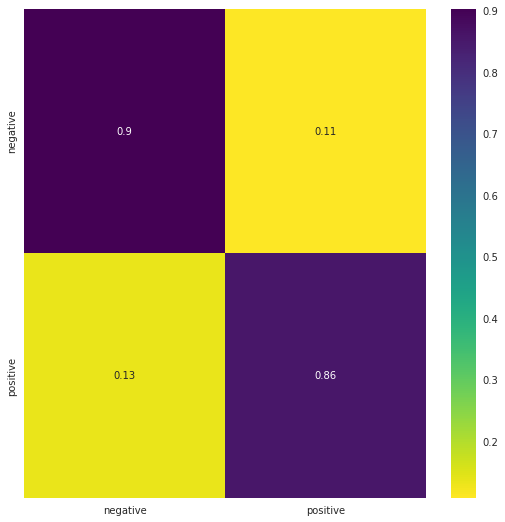

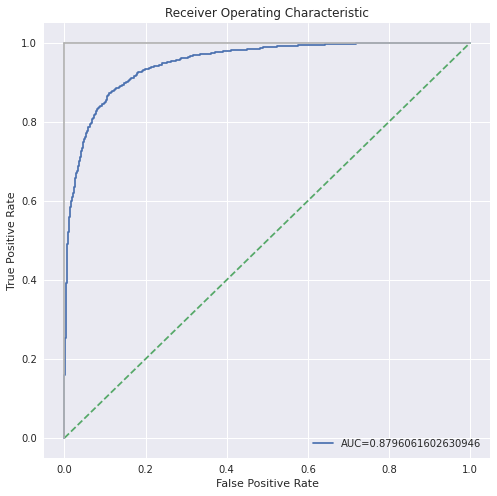

In [108]:
LR = 0.005
EPOCHS = 3
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 34
LAYERS = 2
HEADS = 2
CLASSES = 2

seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This performed slightly worse so I'll try with three heads below.

Epoch 1
__________________________________
loss: 0.693182  [    0/12242]
loss: 0.745377  [ 9280/12242]
loss: 0.772429  [25088/12242]
loss: 0.637819  [93504/12242]
loss: 0.288406  [36096/12242]
loss: 0.487996  [58560/12242]

Evaluation Results
_________________________________
Predicted 1832 / 2160 correctly
Mean Loss: 0.35 
Recall: 83.90%
Precision: 84.87%
Accuracy: 84.81%
Macro Averaged F1-score: 84.80%
_________________________________
Training loss:  0.5526833214040836  validation loss:  0.3501032647841117  and accuracy:  84.81481481481481
__________________________________
Epoch 2
__________________________________
loss: 0.264960  [    0/12242]
loss: 0.266485  [ 9280/12242]
loss: 0.312501  [15872/12242]
loss: 0.195988  [70848/12242]
loss: 0.177282  [12544/12242]
loss: 0.424173  [69440/12242]

Evaluation Results
_________________________________
Predicted 1860 / 2160 correctly
Mean Loss: 0.37 
Recall: 76.99%
Precision: 93.45%
Accuracy: 86.11%
Macro Averaged F1-score: 85.95%
________

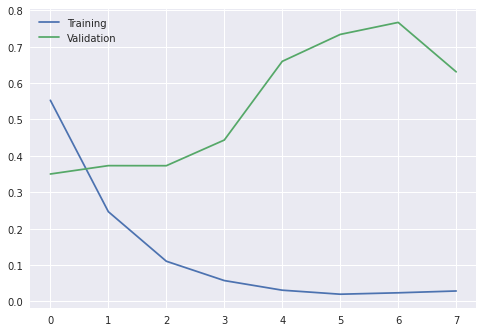

Best F1 score after  2  epochs.
Training Time: 2.80 minutes

Evaluation Results
_________________________________
Predicted 3160 / 3601 correctly
Mean Loss: 0.34 
Recall: 85.06%
Precision: 89.64%
Accuracy: 87.75%
Macro Averaged F1-score: 87.74%
_________________________________


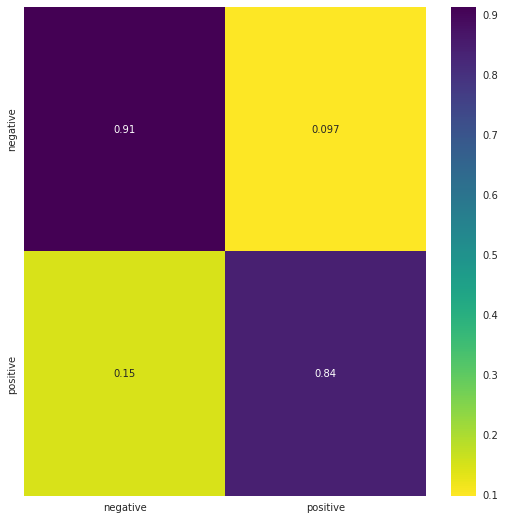

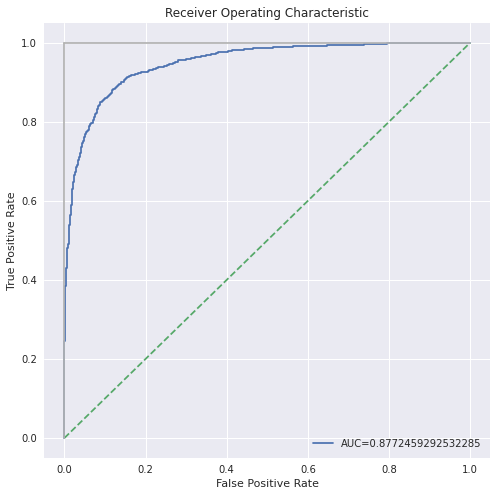

In [110]:
LR = 0.005
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 32
LAYERS = 3
HEADS = 3
CLASSES = 2

seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Again this seems to perform worse. Also to confirm that the network stops learning I'll use my earlystopping function with patience 2 below, to also trial this helper function that I'll be using later.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.45 minutes

Evaluation Results
_________________________________
Predicted 3148 / 3601 correctly
Mean Loss: 0.47 
Recall: 85.18%
Precision: 88.92%
Accuracy: 87.42%
Macro Averaged F1-score: 87.41%
_________________________________


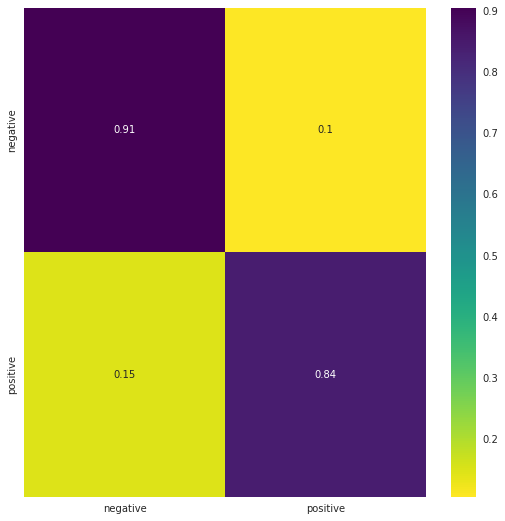

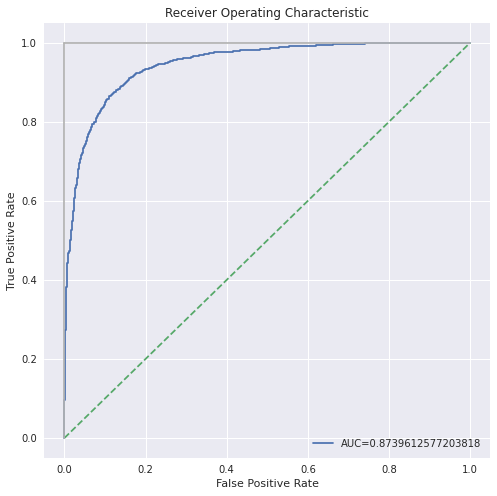

In [118]:
LR = 0.005
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 32
LAYERS = 3
HEADS = 3
CLASSES = 2
PATIENCE = 2
seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The model stops learning as expected very soon. I'll then trial with three heads and the best hidden size that I have found.

Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 0.82 minutes

Evaluation Results
_________________________________
Predicted 3195 / 3601 correctly
Mean Loss: 0.37 
Recall: 89.16%
Precision: 88.17%
Accuracy: 88.73%
Macro Averaged F1-score: 88.73%
_________________________________


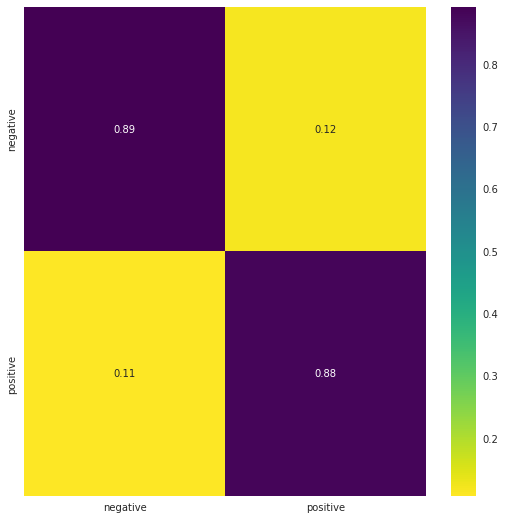

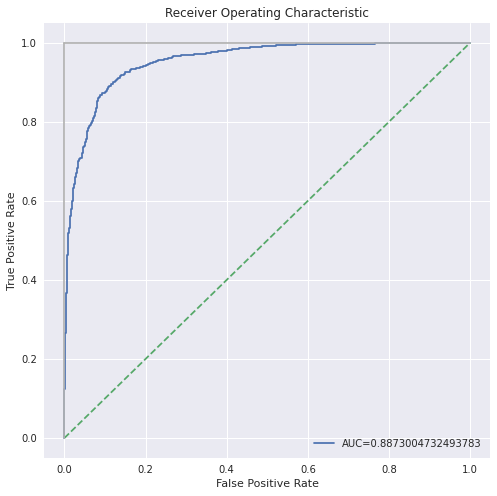

In [119]:
LR = 0.004
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 64
LAYERS = 2
HEADS = 3
CLASSES = 2
PATIENCE = 1
seedTorch()
model = GRU_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

So it's easy to see that 2 layers achieves the best score with 3 or 4 headed attention. Finally, comparing attention to the same network without it below.

Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 0.79 minutes

Evaluation Results
_________________________________
Predicted 3161 / 3601 correctly
Mean Loss: 0.32 
Recall: 84.78%
Precision: 89.93%
Accuracy: 87.78%
Macro Averaged F1-score: 87.76%
_________________________________


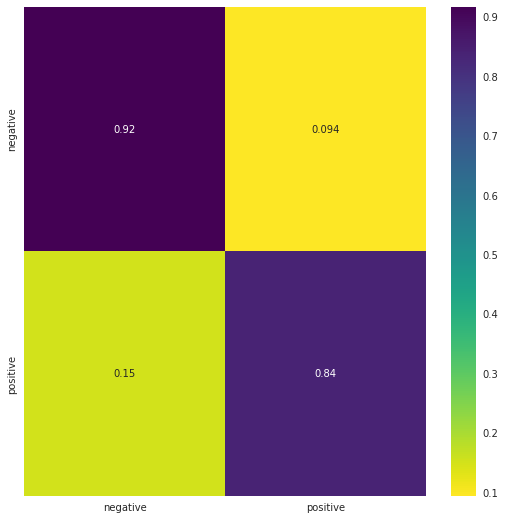

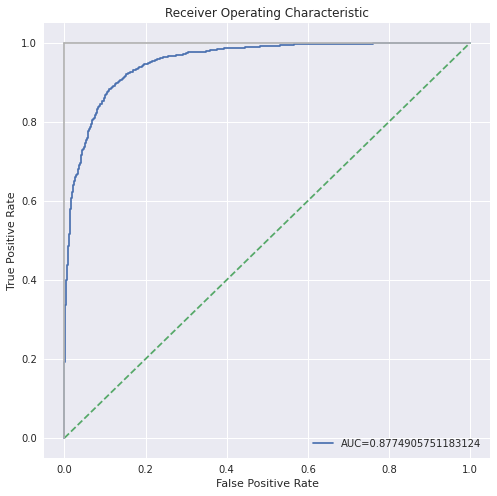

In [120]:
LR = 0.004
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 64
LAYERS = 2
CLASSES = 2
PATIENCE = 1
seedTorch()
model = GRU_03(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

It is obvious that attention has an important benefit to the model so I'll be using it in my networks as I tune the network further.

### Dropout Probability and Finetuning

From this point on I'll incorporate Dropout Probability as well as experiment further with the layers.

In [125]:
class GRU_05(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        # Concatenate the attention along the hidden size dimension
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output

Initially I'll trial the Dropout Probabilities as well as the hidden layers size for a two layered GRU network.

Testing with Hidden Size:  16  Dropout:  0.15
Best F1 score after  0  epochs.
Training Time: 0.27 minutes

Evaluation Results
_________________________________
Predicted 3014 / 3601 correctly
Mean Loss: 0.36 
Recall: 90.01%
Precision: 79.67%
Accuracy: 83.70%
Macro Averaged F1-score: 83.65%
_________________________________


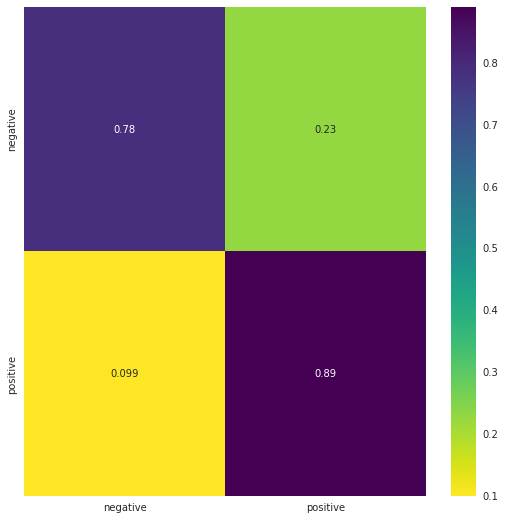

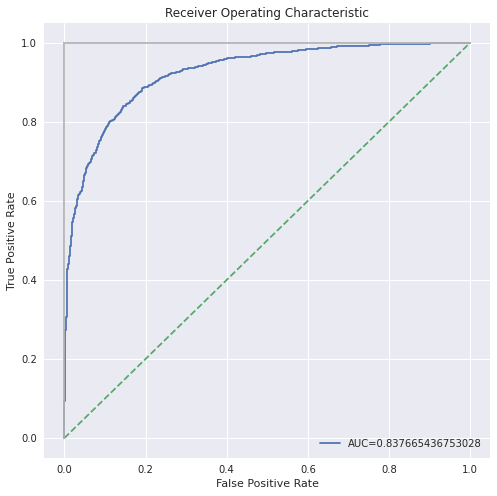

Testing with Hidden Size:  16  Dropout:  0.3
Best F1 score after  0  epochs.
Training Time: 0.24 minutes

Evaluation Results
_________________________________
Predicted 3066 / 3601 correctly
Mean Loss: 0.35 
Recall: 81.75%
Precision: 87.39%
Accuracy: 85.14%
Macro Averaged F1-score: 85.12%
_________________________________


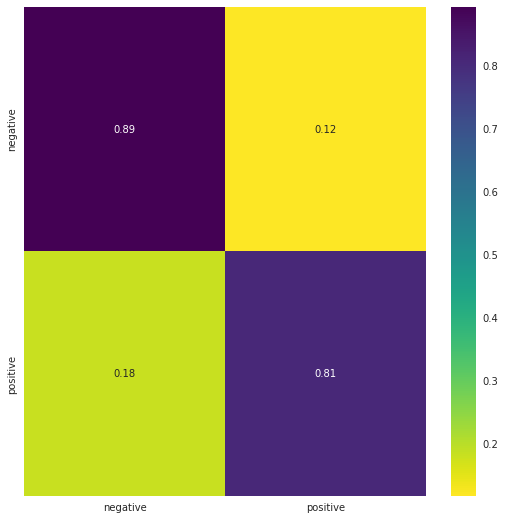

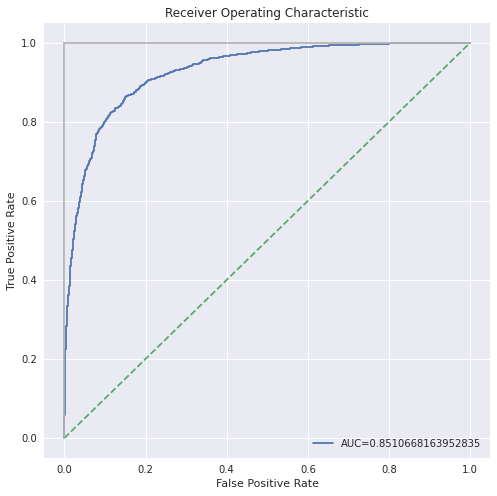

Testing with Hidden Size:  16  Dropout:  0.44999999999999996
Best F1 score after  0  epochs.
Training Time: 0.25 minutes

Evaluation Results
_________________________________
Predicted 2850 / 3601 correctly
Mean Loss: 0.52 
Recall: 94.16%
Precision: 72.16%
Accuracy: 79.14%
Macro Averaged F1-score: 78.73%
_________________________________


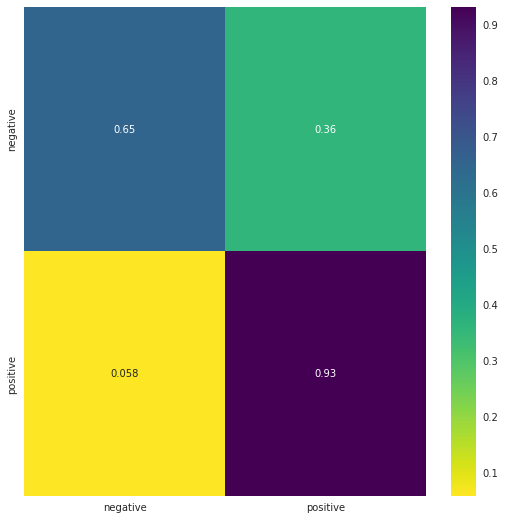

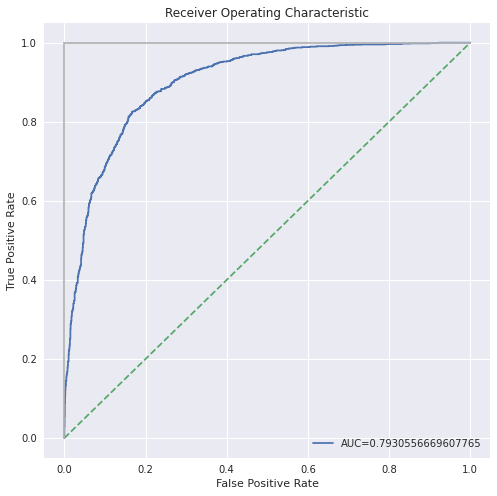

Testing with Hidden Size:  16  Dropout:  0.6
Best F1 score after  0  epochs.
Training Time: 0.24 minutes

Evaluation Results
_________________________________
Predicted 2860 / 3601 correctly
Mean Loss: 0.45 
Recall: 67.10%
Precision: 88.52%
Accuracy: 79.42%
Macro Averaged F1-score: 79.07%
_________________________________


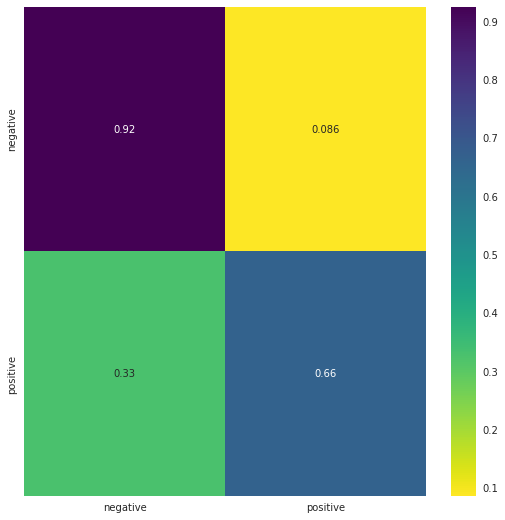

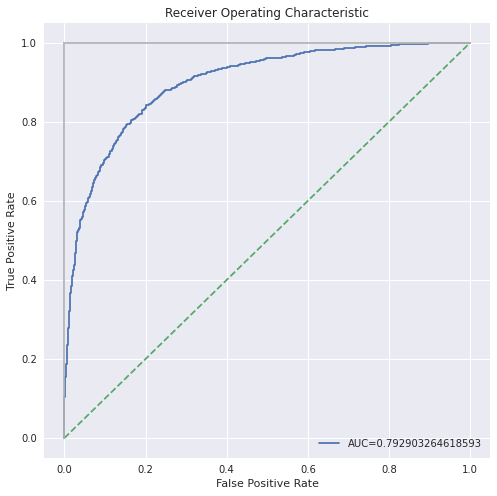

Testing with Hidden Size:  32  Dropout:  0.15
Best F1 score after  0  epochs.
Training Time: 0.25 minutes

Evaluation Results
_________________________________
Predicted 2964 / 3601 correctly
Mean Loss: 0.41 
Recall: 94.55%
Precision: 75.72%
Accuracy: 82.31%
Macro Averaged F1-score: 82.08%
_________________________________


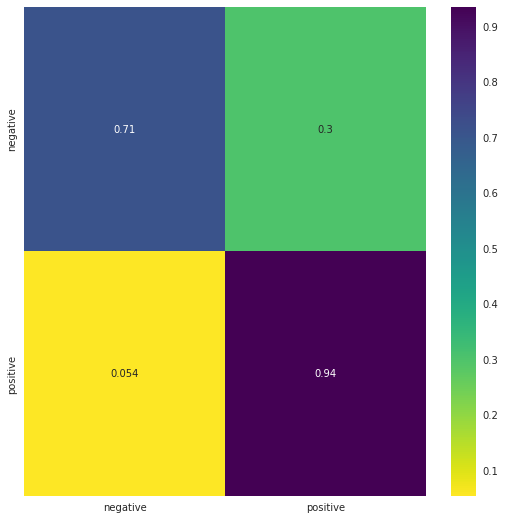

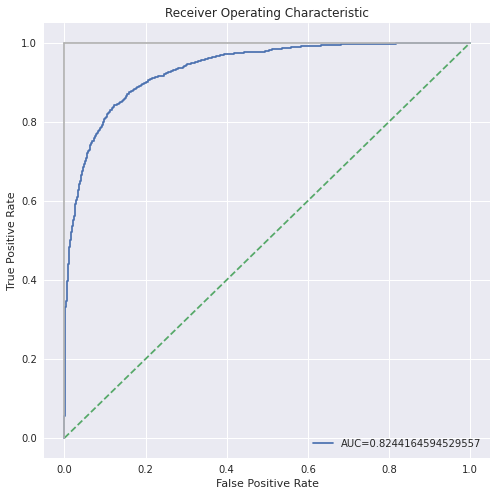

Testing with Hidden Size:  32  Dropout:  0.3
Best F1 score after  0  epochs.
Training Time: 0.25 minutes

Evaluation Results
_________________________________
Predicted 3058 / 3601 correctly
Mean Loss: 0.33 
Recall: 88.15%
Precision: 82.54%
Accuracy: 84.92%
Macro Averaged F1-score: 84.91%
_________________________________


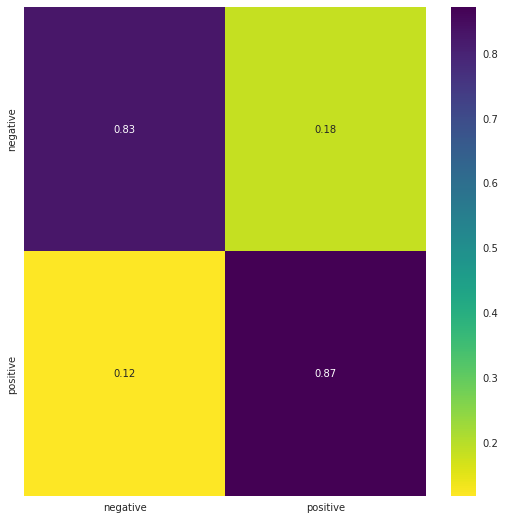

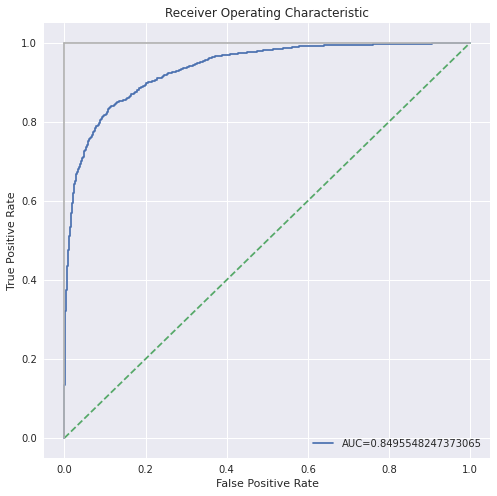

Testing with Hidden Size:  32  Dropout:  0.44999999999999996
Best F1 score after  0  epochs.
Training Time: 0.25 minutes

Evaluation Results
_________________________________
Predicted 3070 / 3601 correctly
Mean Loss: 0.33 
Recall: 83.32%
Precision: 86.38%
Accuracy: 85.25%
Macro Averaged F1-score: 85.24%
_________________________________


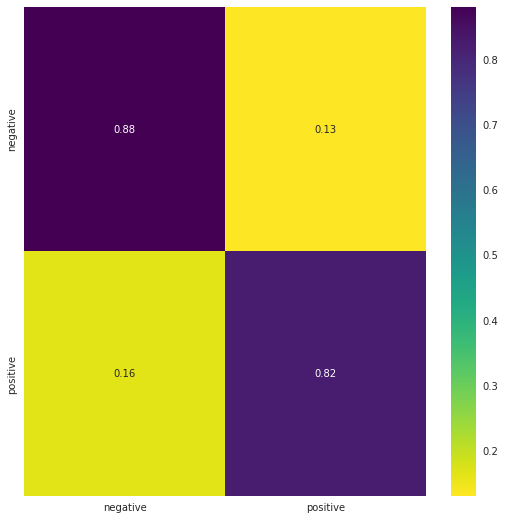

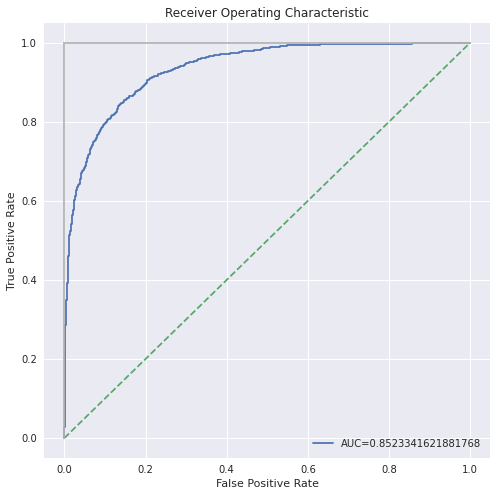

Testing with Hidden Size:  32  Dropout:  0.6
Best F1 score after  0  epochs.
Training Time: 0.25 minutes

Evaluation Results
_________________________________
Predicted 3028 / 3601 correctly
Mean Loss: 0.37 
Recall: 79.17%
Precision: 87.47%
Accuracy: 84.09%
Macro Averaged F1-score: 84.03%
_________________________________


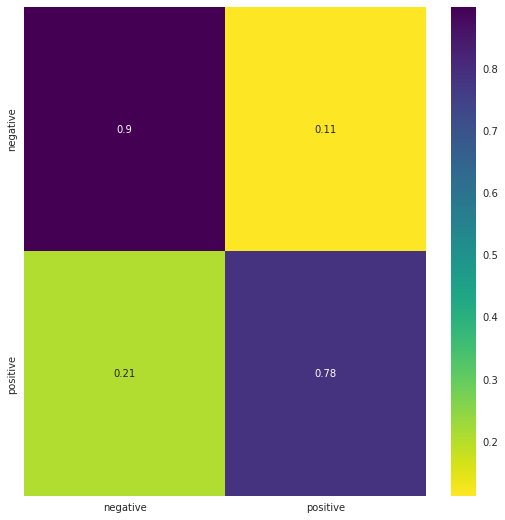

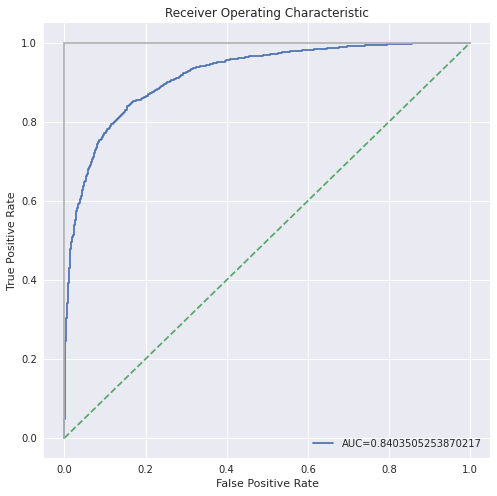

Testing with Hidden Size:  48  Dropout:  0.15
Best F1 score after  0  epochs.
Training Time: 0.26 minutes

Evaluation Results
_________________________________
Predicted 3096 / 3601 correctly
Mean Loss: 0.33 
Recall: 86.75%
Precision: 85.17%
Accuracy: 85.98%
Macro Averaged F1-score: 85.98%
_________________________________


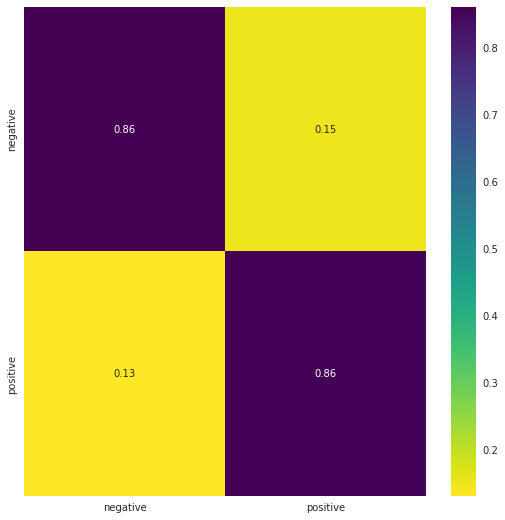

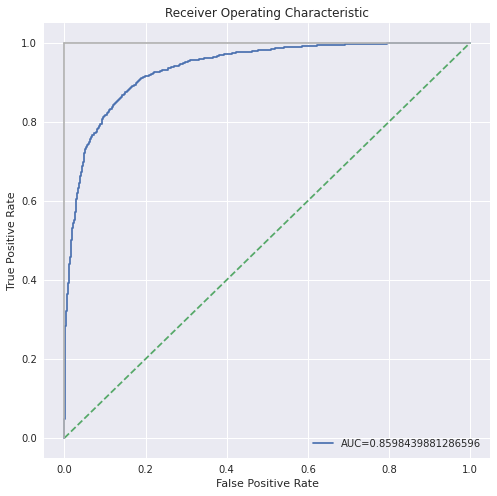

Testing with Hidden Size:  48  Dropout:  0.3
Best F1 score after  0  epochs.
Training Time: 0.27 minutes

Evaluation Results
_________________________________
Predicted 3078 / 3601 correctly
Mean Loss: 0.33 
Recall: 87.20%
Precision: 84.04%
Accuracy: 85.48%
Macro Averaged F1-score: 85.48%
_________________________________


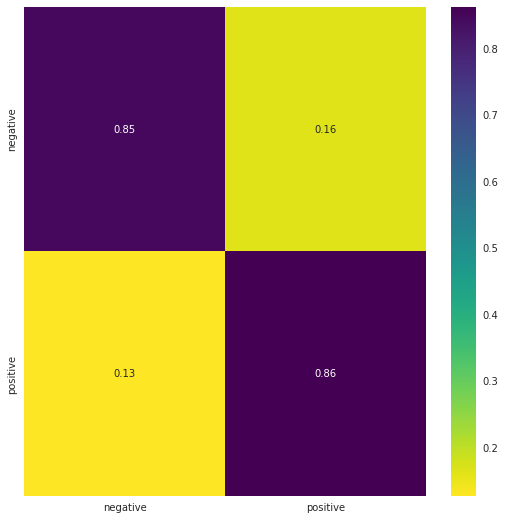

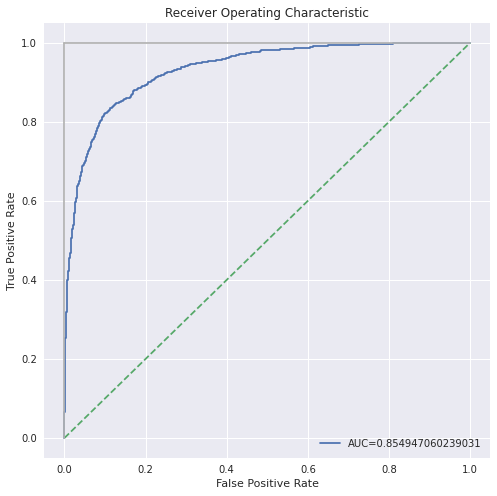

Testing with Hidden Size:  48  Dropout:  0.44999999999999996
Best F1 score after  0  epochs.
Training Time: 0.26 minutes

Evaluation Results
_________________________________
Predicted 2952 / 3601 correctly
Mean Loss: 0.44 
Recall: 95.17%
Precision: 75.07%
Accuracy: 81.98%
Macro Averaged F1-score: 81.71%
_________________________________


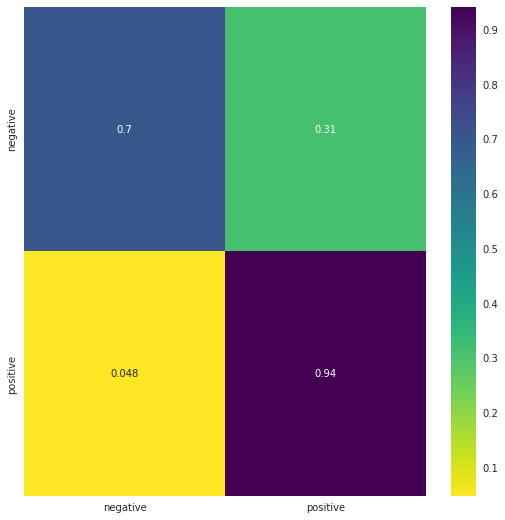

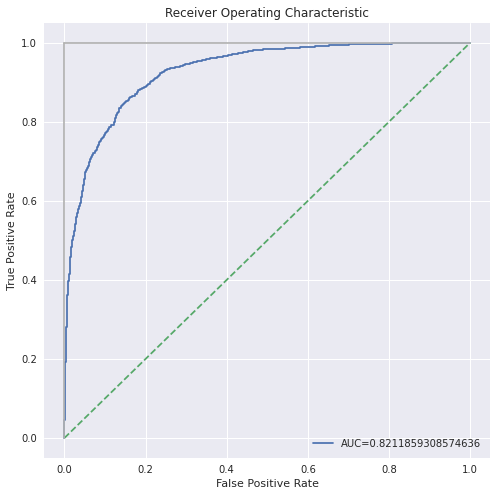

Testing with Hidden Size:  48  Dropout:  0.6
Best F1 score after  0  epochs.
Training Time: 0.27 minutes

Evaluation Results
_________________________________
Predicted 3022 / 3601 correctly
Mean Loss: 0.36 
Recall: 89.28%
Precision: 80.38%
Accuracy: 83.92%
Macro Averaged F1-score: 83.89%
_________________________________


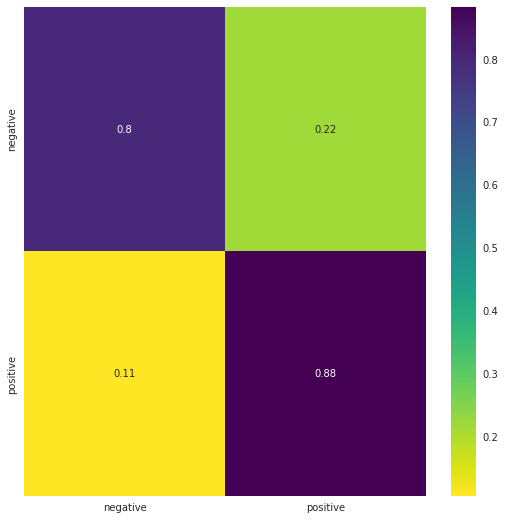

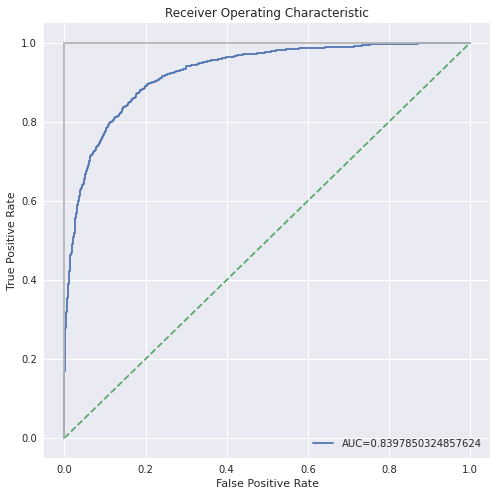

In [127]:
LR = 0.004
EPOCHS = 1
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 16
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 1

for i in range(3):
    for j in range(4):
        HIDDEN = 16*(i+1)
        DROPOUT = 0.15*(j+1)
        print("Testing with Hidden Size: ", HIDDEN, " Dropout: ", DROPOUT)
        seedTorch()
        model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
        optimizer = torch.optim.Adam
        lossfunc = nn.CrossEntropyLoss()
        start_time = time.time()
        model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
        print("Best F1 score after ", bestEp, " epochs.")
        print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')
        # Evaluate on the test set and print confusion matrix and roc curve
        trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
        confusionMatrix(trues, preds)
        roc_auc = rocCurve(trues, preds, probs)

The best performance was with dropout 0.15 and hidden layer 48 so I'll test on the network below.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.07 minutes

Evaluation Results
_________________________________
Predicted 3176 / 3601 correctly
Mean Loss: 0.47 
Recall: 88.83%
Precision: 87.50%
Accuracy: 88.20%
Macro Averaged F1-score: 88.20%
_________________________________


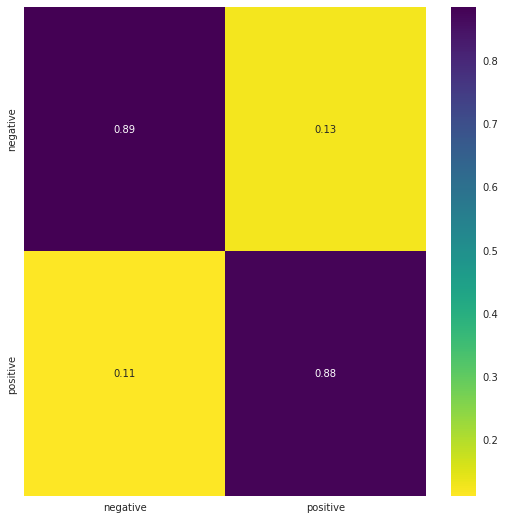

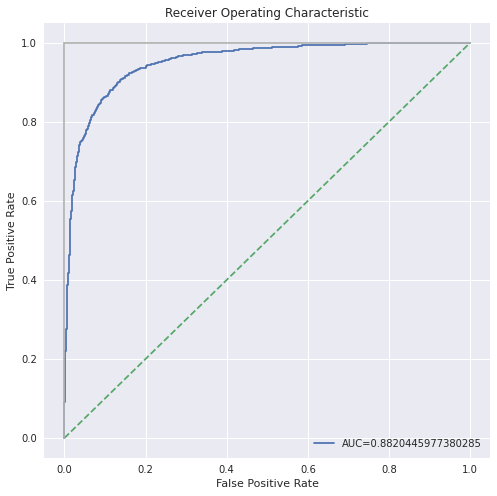

In [128]:
LR = 0.004
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Then I'll experiment with the learning rate using values close to the ones I got with Optuna.

Learning Rate  0.001
Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 1.34 minutes

Evaluation Results
_________________________________
Predicted 3065 / 3601 correctly
Mean Loss: 0.51 
Recall: 92.53%
Precision: 80.35%
Accuracy: 85.12%
Macro Averaged F1-score: 85.05%
_________________________________


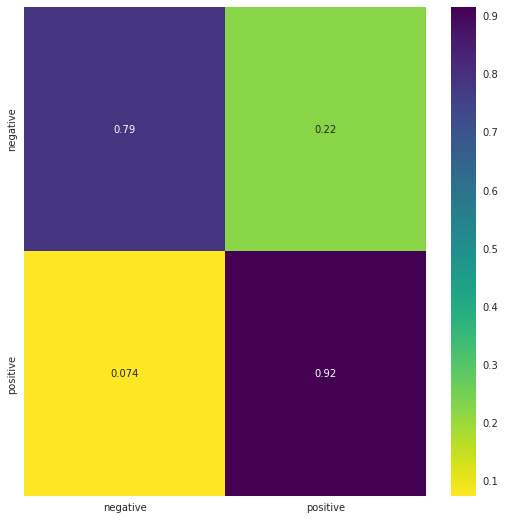

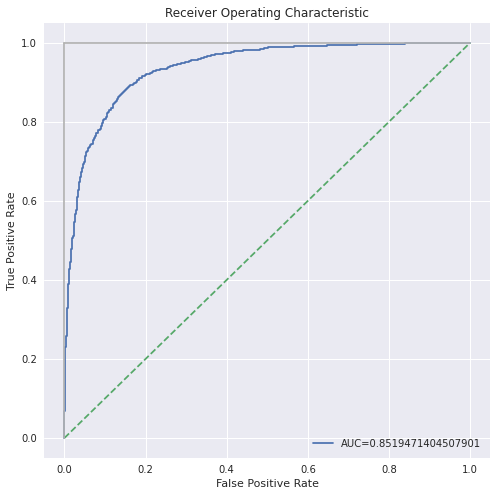

Learning Rate  0.0015
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.05 minutes

Evaluation Results
_________________________________
Predicted 3072 / 3601 correctly
Mean Loss: 0.42 
Recall: 93.32%
Precision: 80.21%
Accuracy: 85.31%
Macro Averaged F1-score: 85.24%
_________________________________


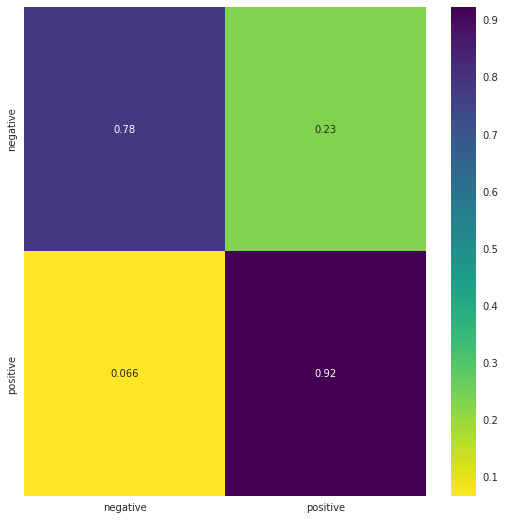

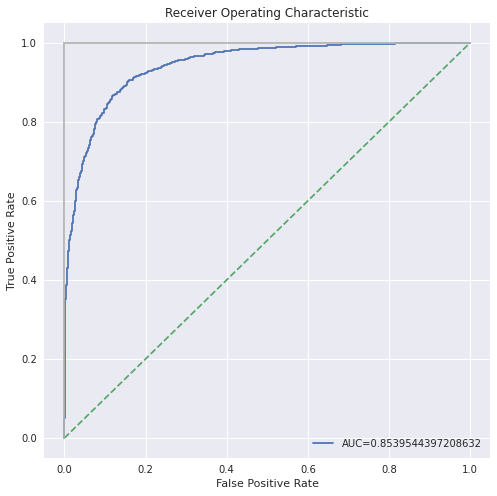

Learning Rate  0.002
Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 1.32 minutes

Evaluation Results
_________________________________
Predicted 3163 / 3601 correctly
Mean Loss: 0.55 
Recall: 88.99%
Precision: 86.75%
Accuracy: 87.84%
Macro Averaged F1-score: 87.84%
_________________________________


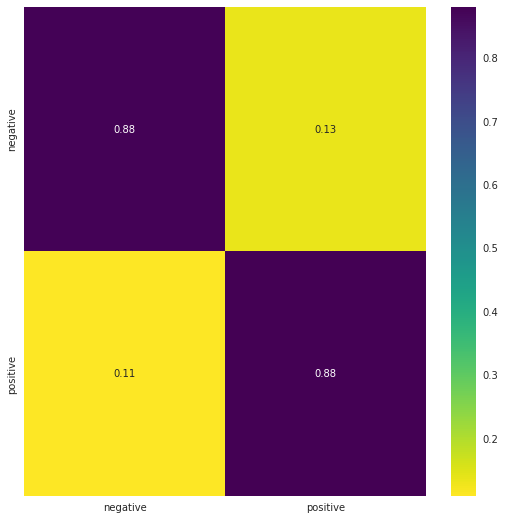

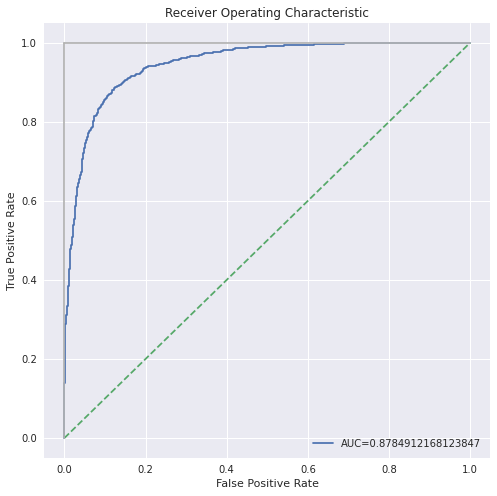

Learning Rate  0.0025
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.06 minutes

Evaluation Results
_________________________________
Predicted 3093 / 3601 correctly
Mean Loss: 0.56 
Recall: 94.10%
Precision: 80.62%
Accuracy: 85.89%
Macro Averaged F1-score: 85.82%
_________________________________


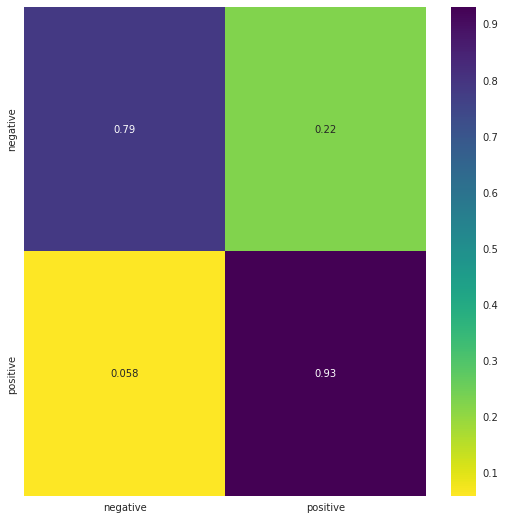

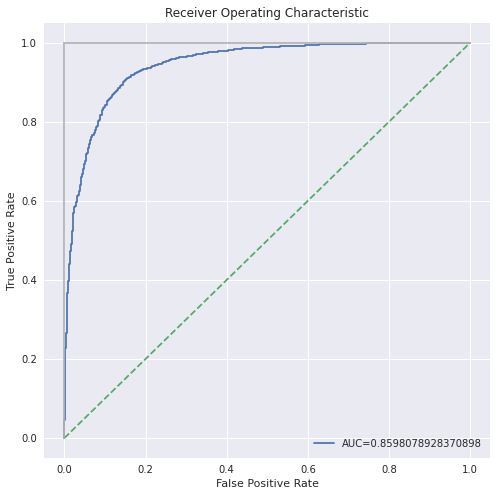

Learning Rate  0.003
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.06 minutes

Evaluation Results
_________________________________
Predicted 3131 / 3601 correctly
Mean Loss: 0.54 
Recall: 92.53%
Precision: 83.02%
Accuracy: 86.95%
Macro Averaged F1-score: 86.92%
_________________________________


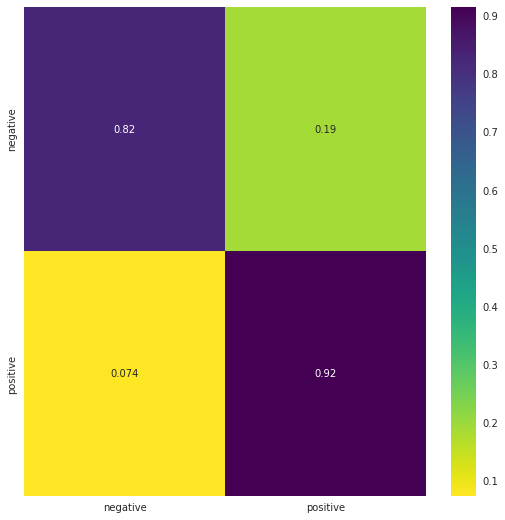

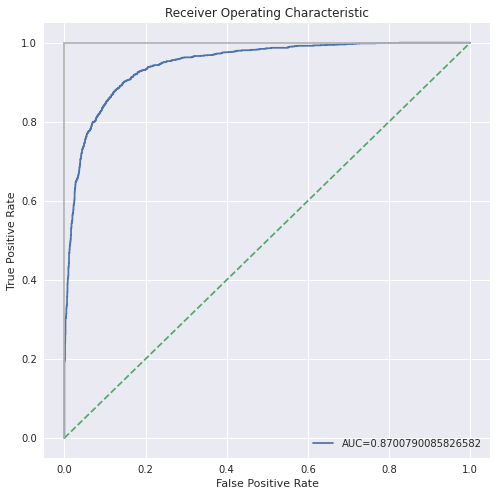

Learning Rate  0.0035
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.06 minutes

Evaluation Results
_________________________________
Predicted 3121 / 3601 correctly
Mean Loss: 0.50 
Recall: 92.03%
Precision: 82.90%
Accuracy: 86.67%
Macro Averaged F1-score: 86.64%
_________________________________


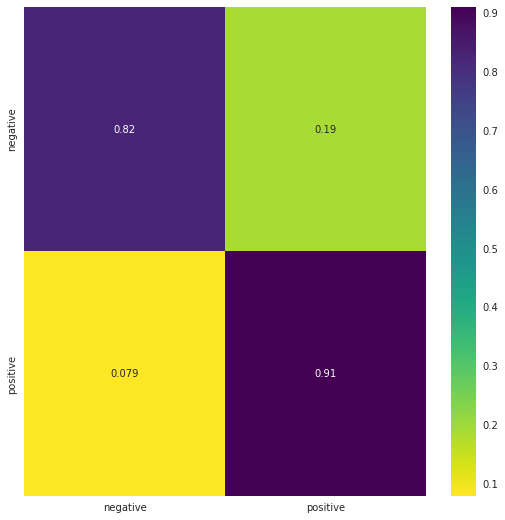

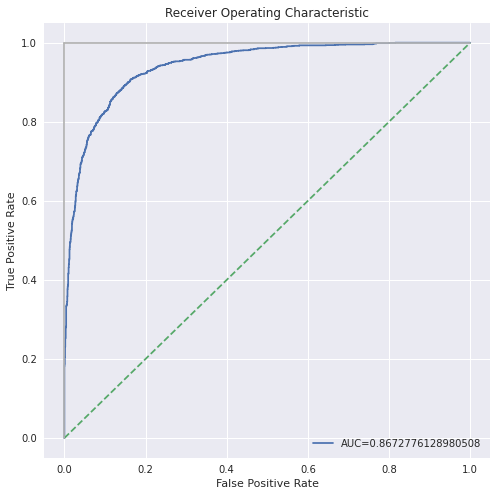

Learning Rate  0.004
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.06 minutes

Evaluation Results
_________________________________
Predicted 3089 / 3601 correctly
Mean Loss: 0.68 
Recall: 94.78%
Precision: 80.11%
Accuracy: 85.78%
Macro Averaged F1-score: 85.69%
_________________________________


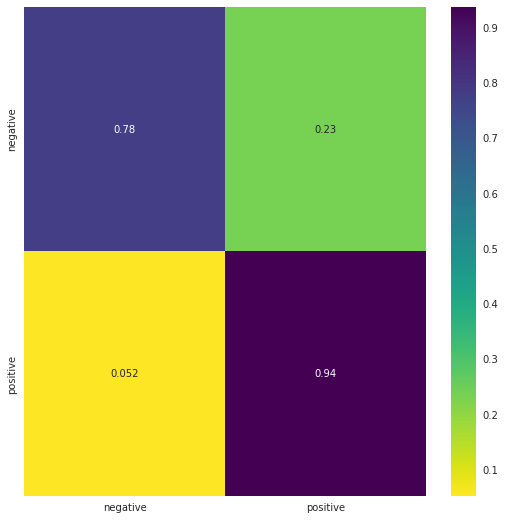

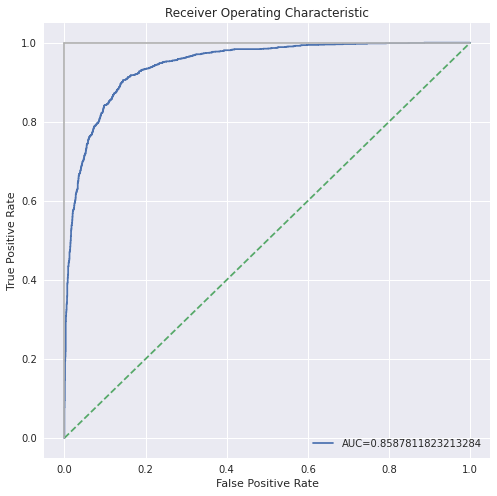

Learning Rate  0.0045000000000000005
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 0.80 minutes

Evaluation Results
_________________________________
Predicted 3191 / 3601 correctly
Mean Loss: 0.36 
Recall: 87.59%
Precision: 89.19%
Accuracy: 88.61%
Macro Averaged F1-score: 88.61%
_________________________________


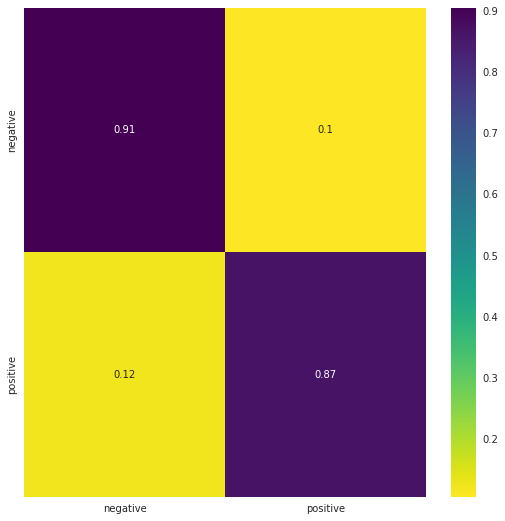

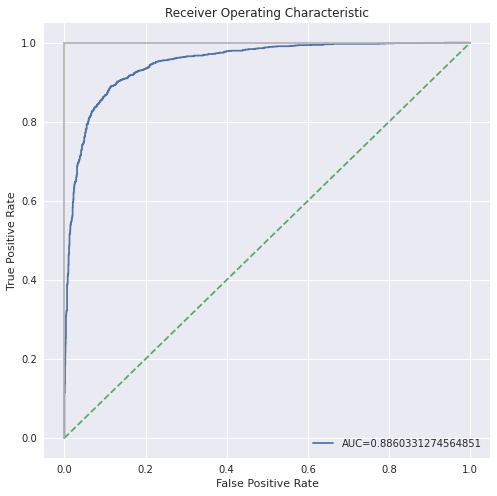

Learning Rate  0.005000000000000001
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.07 minutes

Evaluation Results
_________________________________
Predicted 3110 / 3601 correctly
Mean Loss: 0.55 
Recall: 92.64%
Precision: 82.09%
Accuracy: 86.36%
Macro Averaged F1-score: 86.33%
_________________________________


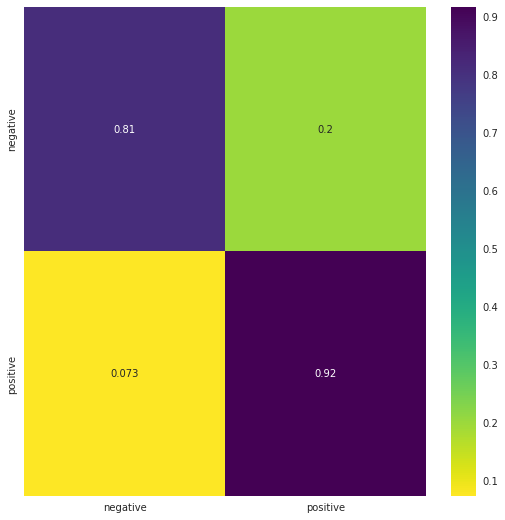

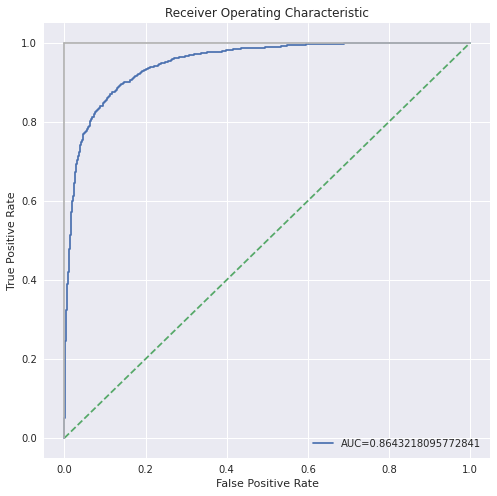

Learning Rate  0.0055
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.06 minutes

Evaluation Results
_________________________________
Predicted 3133 / 3601 correctly
Mean Loss: 0.45 
Recall: 87.03%
Precision: 86.74%
Accuracy: 87.00%
Macro Averaged F1-score: 87.00%
_________________________________


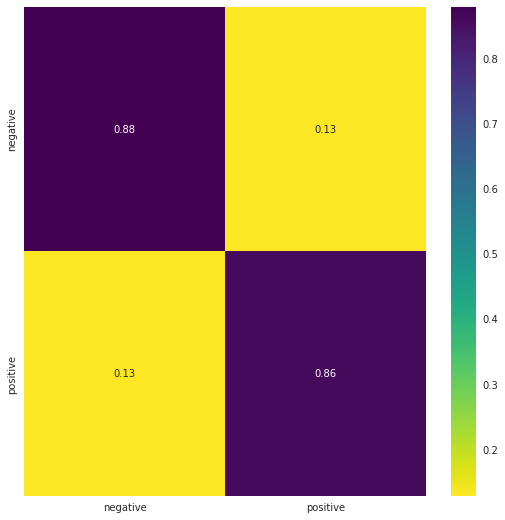

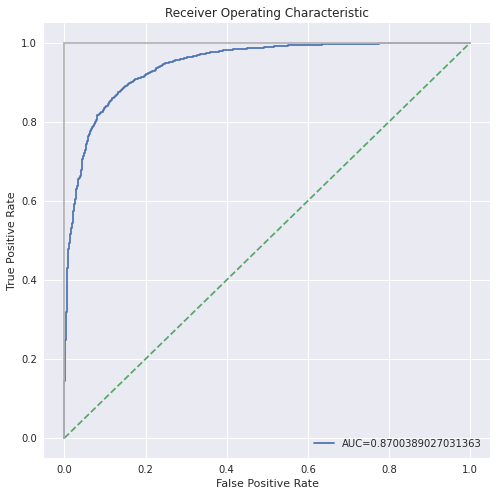

Learning Rate  0.006
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.06 minutes

Evaluation Results
_________________________________
Predicted 3146 / 3601 correctly
Mean Loss: 0.40 
Recall: 85.74%
Precision: 88.37%
Accuracy: 87.36%
Macro Averaged F1-score: 87.36%
_________________________________


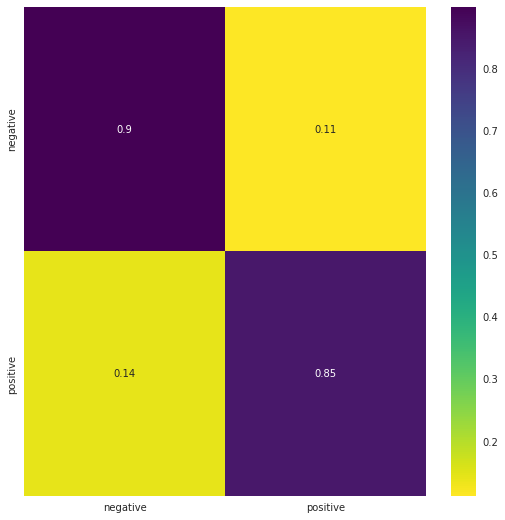

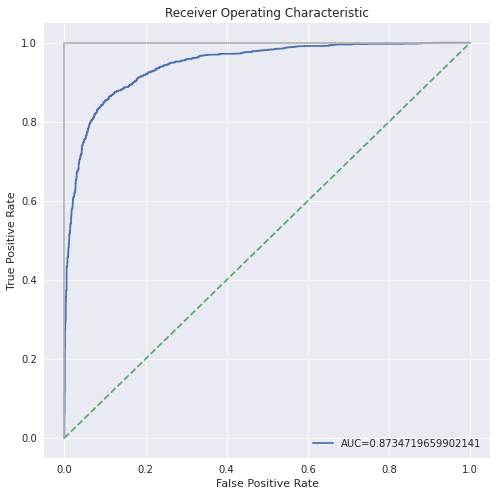

Learning Rate  0.006500000000000001
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.05 minutes

Evaluation Results
_________________________________
Predicted 3163 / 3601 correctly
Mean Loss: 0.52 
Recall: 85.51%
Precision: 89.43%
Accuracy: 87.84%
Macro Averaged F1-score: 87.82%
_________________________________


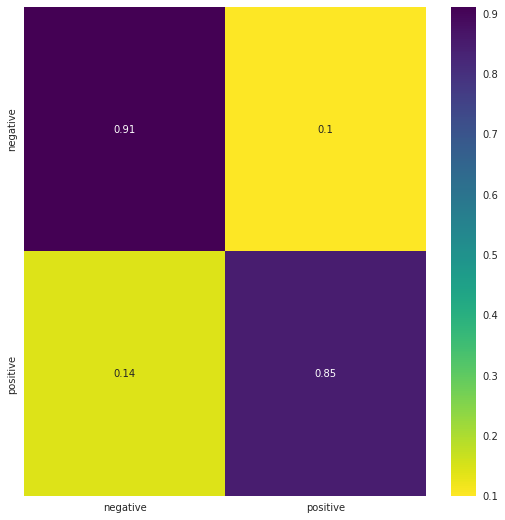

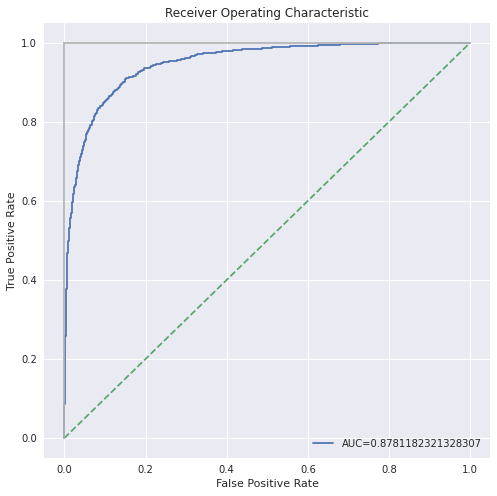

In [134]:
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

for i in range(12):
    LR = 0.0005+(i+1)*0.0005
    print("Learning Rate ", LR)
    seedTorch()
    model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
    optimizer = torch.optim.Adam
    lossfunc = nn.CrossEntropyLoss()
    start_time = time.time()
    model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
    print("Best F1 score after ", bestEp, " epochs.")
    print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

    # Evaluate on the test set and print confusion matrix and roc curve
    trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
    confusionMatrix(trues, preds)
    roc_auc = rocCurve(trues, preds, probs)

This confirms my prevous experiments that around 0.0045 is the best.

## Batch size

Now using these parameters I will test the network with different batch sizes.


Batch Size  16
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.92 minutes

Evaluation Results
_________________________________
Predicted 3151 / 3601 correctly
Mean Loss: 0.49 
Recall: 84.17%
Precision: 89.92%
Accuracy: 87.50%
Macro Averaged F1-score: 87.48%
_________________________________


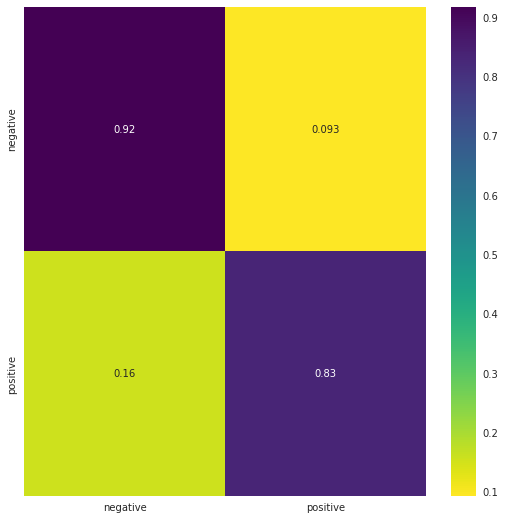

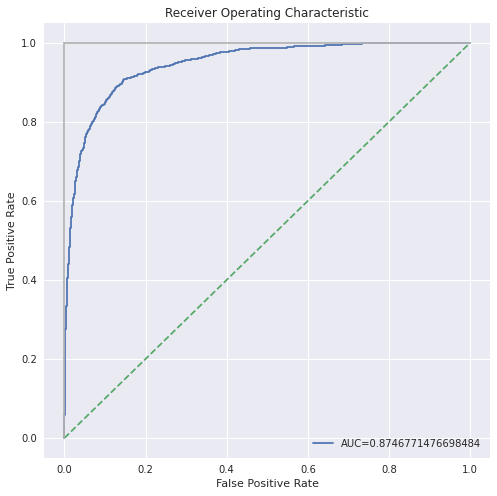

Batch Size  32
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 1.08 minutes

Evaluation Results
_________________________________
Predicted 3172 / 3601 correctly
Mean Loss: 0.51 
Recall: 88.66%
Precision: 87.43%
Accuracy: 88.09%
Macro Averaged F1-score: 88.09%
_________________________________


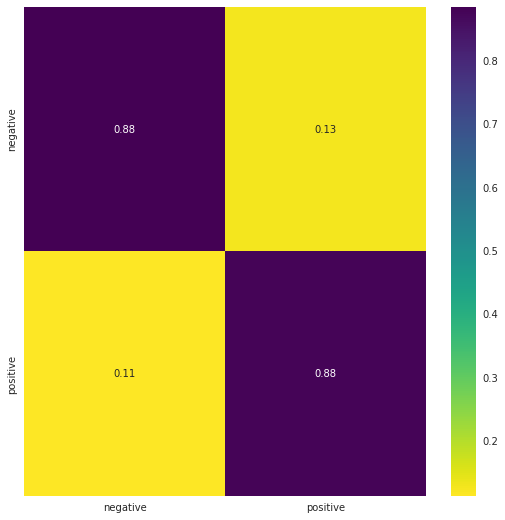

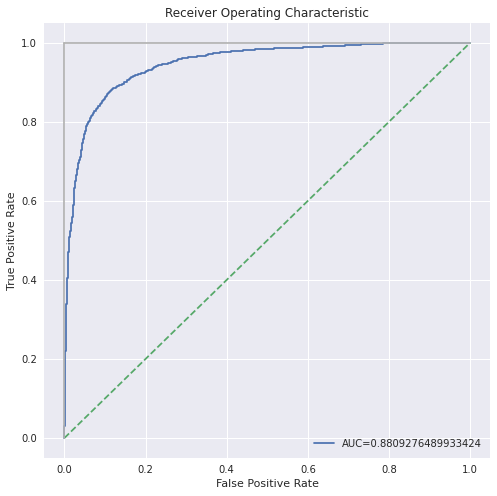

Batch Size  64
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 0.63 minutes

Evaluation Results
_________________________________
Predicted 3120 / 3601 correctly
Mean Loss: 0.52 
Recall: 93.99%
Precision: 81.74%
Accuracy: 86.64%
Macro Averaged F1-score: 86.59%
_________________________________


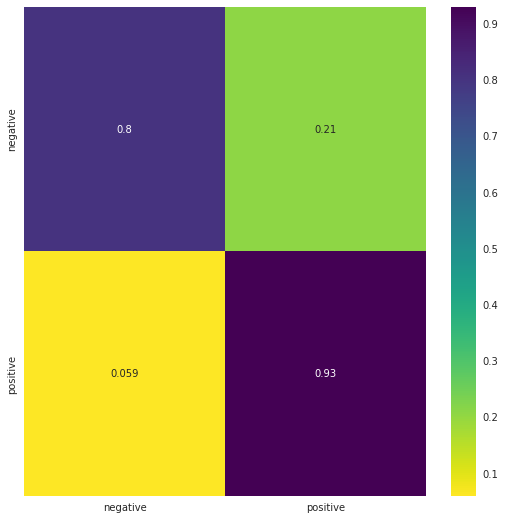

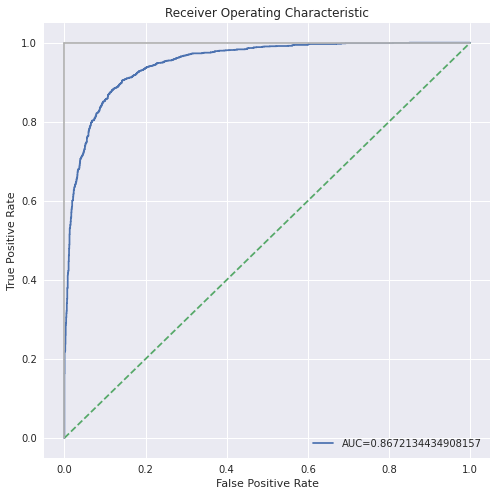

Batch Size  128
Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 0.39 minutes

Evaluation Results
_________________________________
Predicted 3147 / 3601 correctly
Mean Loss: 0.35 
Recall: 88.99%
Precision: 86.00%
Accuracy: 87.39%
Macro Averaged F1-score: 87.39%
_________________________________


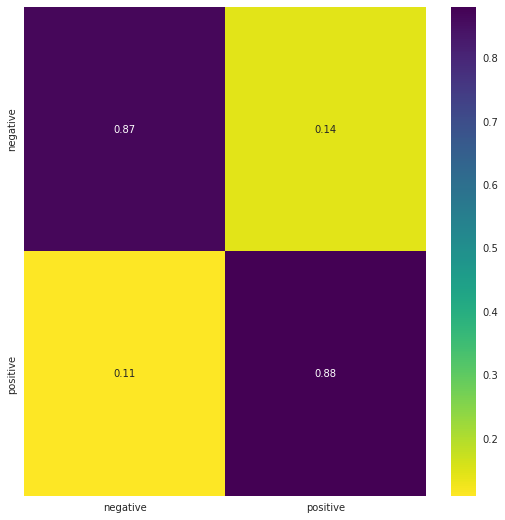

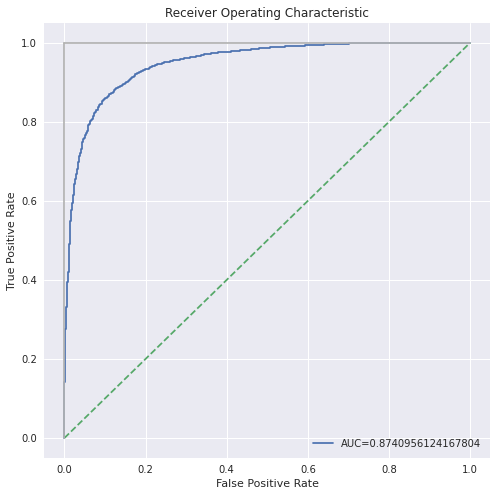

Batch Size  256
Early stopping on epoch:  6
Best F1 score after  6  epochs.
Training Time: 0.43 minutes

Evaluation Results
_________________________________
Predicted 3015 / 3601 correctly
Mean Loss: 0.65 
Recall: 76.70%
Precision: 88.87%
Accuracy: 83.73%
Macro Averaged F1-score: 83.63%
_________________________________


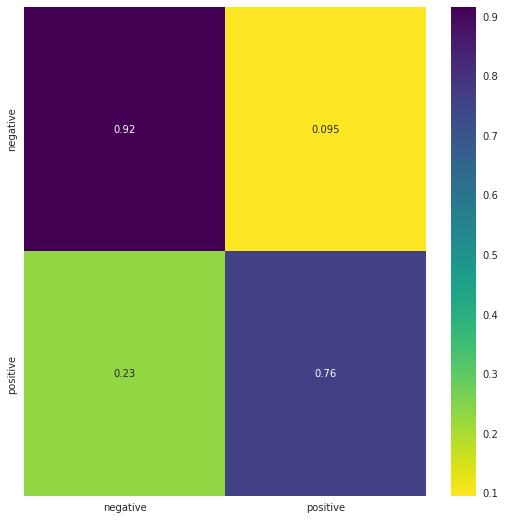

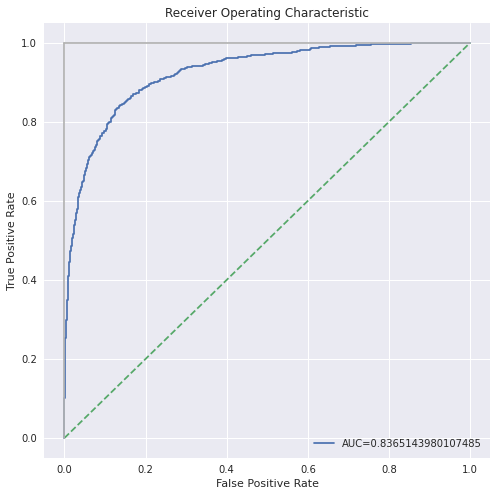

In [146]:
LR = 0.0045
BATCH_SIZES = [16, 32, 64, 128, 256]
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

for BATCH_SIZE in BATCH_SIZES:
    print("Batch Size ", BATCH_SIZE)
    seedTorch()
    train_dataloader, val_dataloader, test_dataloader = torchtext.legacy.data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=BATCH_SIZE, sort_within_batch=True, sort_key=lambda x: len(x.review), device=DEVICE)
    model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
    optimizer = torch.optim.Adam
    lossfunc = nn.CrossEntropyLoss()
    start_time = time.time()
    model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
    print("Best F1 score after ", bestEp, " epochs.")
    print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

    # Evaluate on the test set and print confusion matrix and roc curve
    trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
    confusionMatrix(trues, preds)
    roc_auc = rocCurve(trues, preds, probs)

As expected the smaller batch gives better results and by having a small batch size helps to use even more data later on.

In [147]:
seedTorch()
BATCH_SIZE=32
train_dataloader, val_dataloader, test_dataloader = torchtext.legacy.data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=BATCH_SIZE, sort_within_batch=True, sort_key=lambda x: len(x.review), device=DEVICE)


### Testing LSTM
Then I moved to trialing with LSTM. I define below a version with Attention as the GRU.

In [149]:
class LSTM_01(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.lstm = torch.nn.LSTM(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, (h_0, _) = self.lstm(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        # Concatenate the attention along the hidden size dimension
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output

Then testing for five epochs.

Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 1.38 minutes

Evaluation Results
_________________________________
Predicted 3077 / 3601 correctly
Mean Loss: 0.55 
Recall: 87.82%
Precision: 83.59%
Accuracy: 85.45%
Macro Averaged F1-score: 85.45%
_________________________________


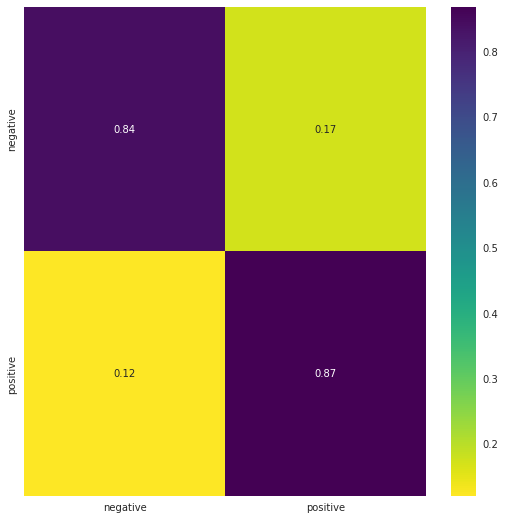

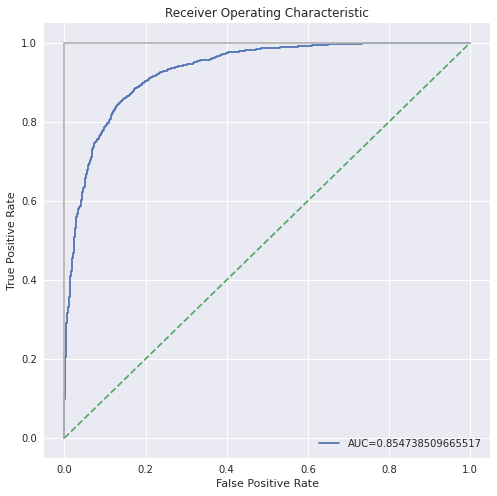

In [151]:
LR = 0.0045
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 1.14 minutes

Evaluation Results
_________________________________
Predicted 3086 / 3601 correctly
Mean Loss: 0.53 
Recall: 88.32%
Precision: 83.67%
Accuracy: 85.70%
Macro Averaged F1-score: 85.69%
_________________________________


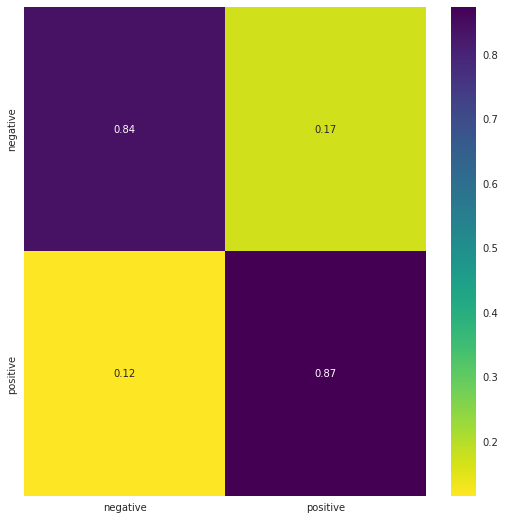

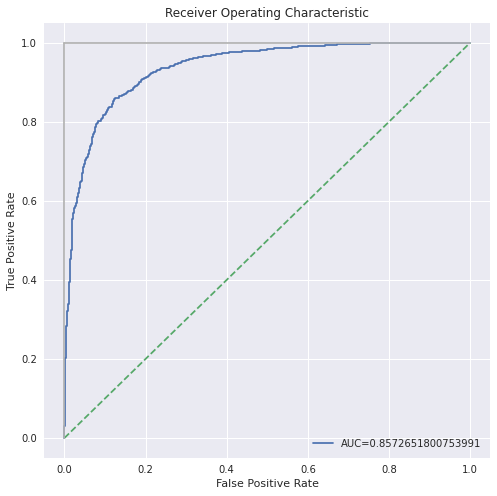

In [152]:
LR = 0.0045
EPOCHS = 8
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 200
LAYERS = 1
DROPOUT = 0.1
HEADS = 2
CLASSES = 2
PATIENCE = 2

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 2.05 minutes

Evaluation Results
_________________________________
Predicted 3107 / 3601 correctly
Mean Loss: 0.48 
Recall: 85.01%
Precision: 86.96%
Accuracy: 86.28%
Macro Averaged F1-score: 86.27%
_________________________________


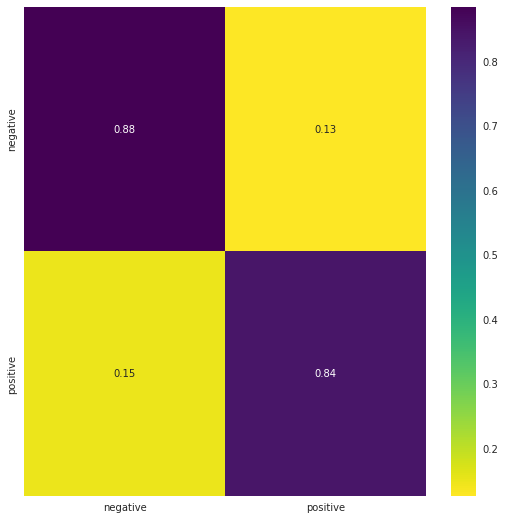

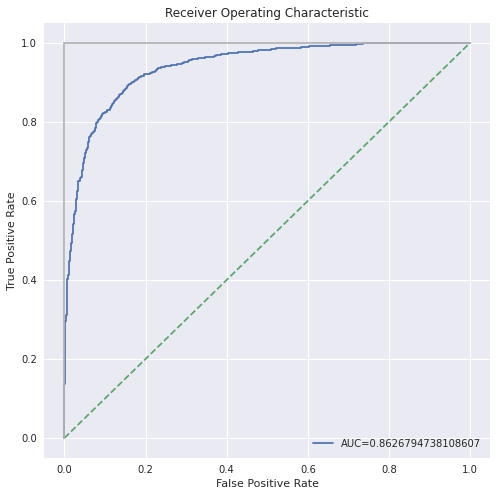

In [153]:
LR = 0.0045
EPOCHS = 12
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 64
LAYERS = 3
DROPOUT = 0.2
HEADS = 3
CLASSES = 2
PATIENCE = 3

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Simpler version without attention to see if this is the problem for the worse performance.

In [170]:
class LSTM_02(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.lstm = torch.nn.LSTM(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=False)
        self.linear = torch.nn.Linear(hidden, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, (h_0, _) = self.lstm(sequence)
        h_0 = h_0.squeeze_(0)
        output = self.linear(h_0)
        return output

Early stopping on epoch:  6
Best F1 score after  6  epochs.
Training Time: 0.61 minutes

Evaluation Results
_________________________________
Predicted 3073 / 3601 correctly
Mean Loss: 0.59 
Recall: 82.87%
Precision: 86.87%
Accuracy: 85.34%
Macro Averaged F1-score: 85.32%
_________________________________


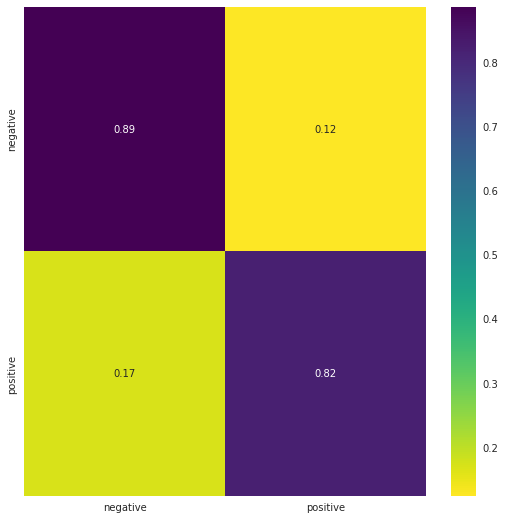

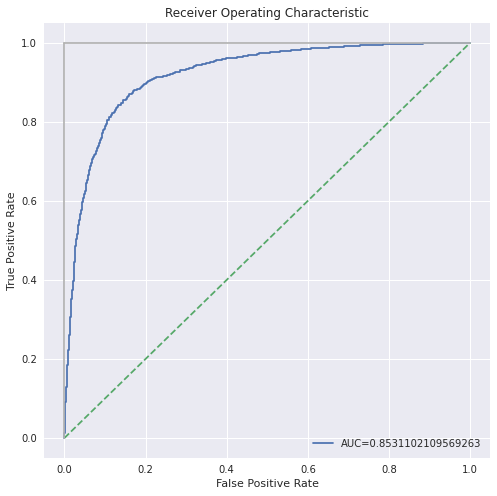

In [171]:
LR = 0.005
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 1
CLASSES = 2
PATIENCE = 3

seedTorch()
model = LSTM_02(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The performance is similar. Looking online I discovered that it must be due to the small data I've been using which isn't adequate for LSTMs as GRUs so I increased the size below.

### Increasing Training Size & Vocabulary

To be able for the LSTM to train I increased both the training size and doubled the vocabulary.

In [176]:
# Field and Label Field for review and sentiment
REVIEW = torchtext.legacy.data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm', include_lengths=True)
SENTIMENT = torchtext.legacy.data.LabelField(dtype=torch.long)
fields = [('review', REVIEW), ('rating', SENTIMENT)]
dataset = torchtext.legacy.data.TabularDataset(path='/kaggle/working/proper_data.csv', format='csv', skip_header=True, fields=fields)
train_dataset, test_dataset = dataset.split(split_ratio=[0.75, 0.25])
train_dataset, val_dataset = train_dataset.split(split_ratio=[0.85, 0.15])
DEVICE = 'cuda'
VOCAB_SIZE = 20000
BATCH_SIZE = 32
REVIEW.build_vocab(train_dataset, max_size=VOCAB_SIZE, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
SENTIMENT.build_vocab(train_dataset)
train_dataloader, val_dataloader, test_dataloader = torchtext.legacy.data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=BATCH_SIZE, sort_within_batch=True, sort_key=lambda x: len(x.review), device=DEVICE)

Then training with the LSTM and early stopping when it stops improving.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 2.73 minutes

Evaluation Results
_________________________________
Predicted 10164 / 11252 correctly
Mean Loss: 0.31 
Recall: 92.91%
Precision: 88.48%
Accuracy: 90.33%
Macro Averaged F1-score: 90.32%
_________________________________


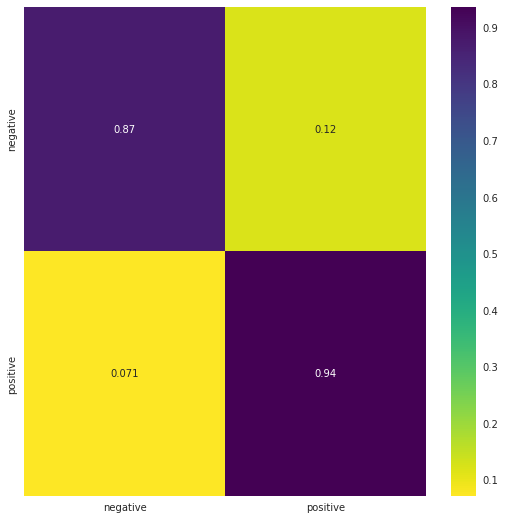

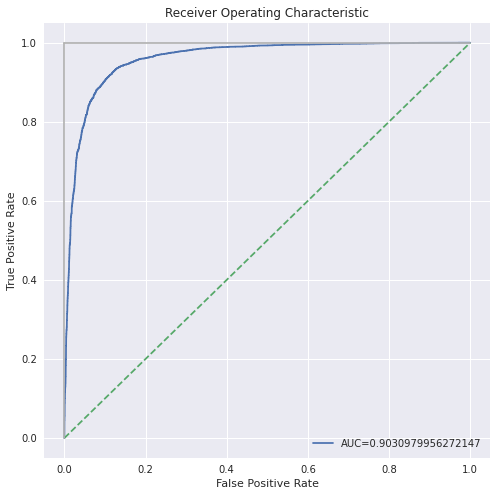

In [180]:
LR = 0.0045
EPOCHS = 20
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This seemed to be the problem as it immediately scored excellently. Then trialing without attention.

Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 1.24 minutes

Evaluation Results
_________________________________
Predicted 9928 / 11252 correctly
Mean Loss: 0.38 
Recall: 88.20%
Precision: 88.42%
Accuracy: 88.23%
Macro Averaged F1-score: 88.23%
_________________________________


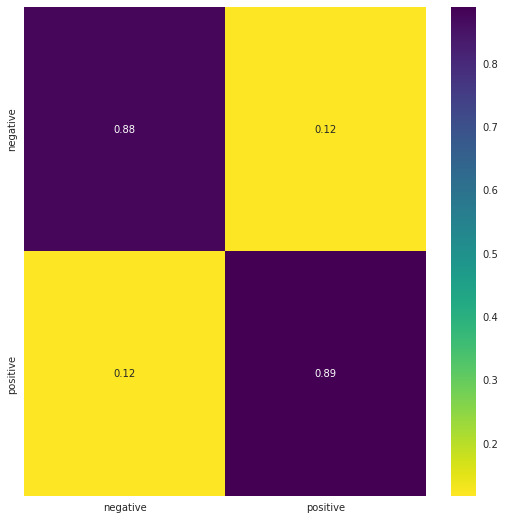

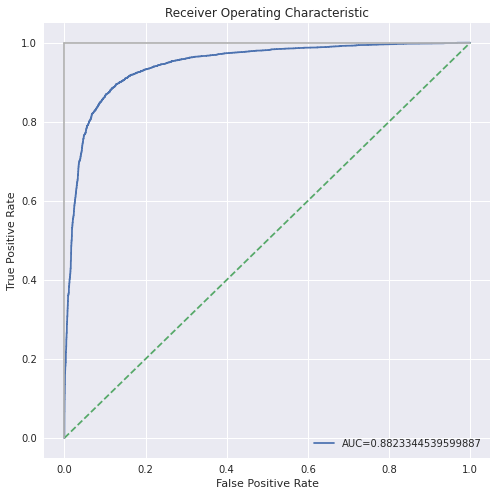

In [177]:
LR = 0.005
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 1
CLASSES = 2
PATIENCE = 3

seedTorch()
model = LSTM_02(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This performed worse so it is obvious the huge benefit has on the LSTM. Then trialing with the same on the GRU.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 2.68 minutes

Evaluation Results
_________________________________
Predicted 10154 / 11252 correctly
Mean Loss: 0.39 
Recall: 92.70%
Precision: 88.49%
Accuracy: 90.24%
Macro Averaged F1-score: 90.23%
_________________________________


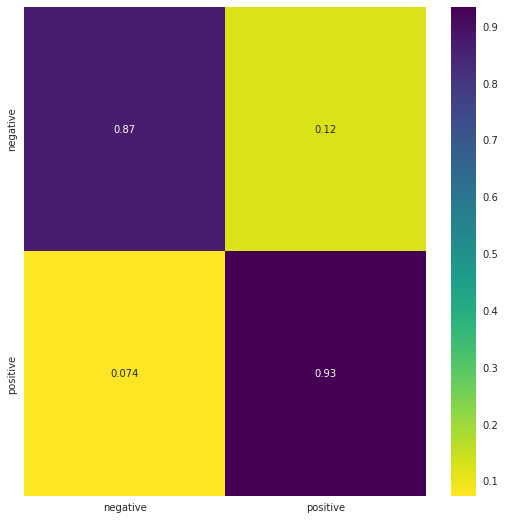

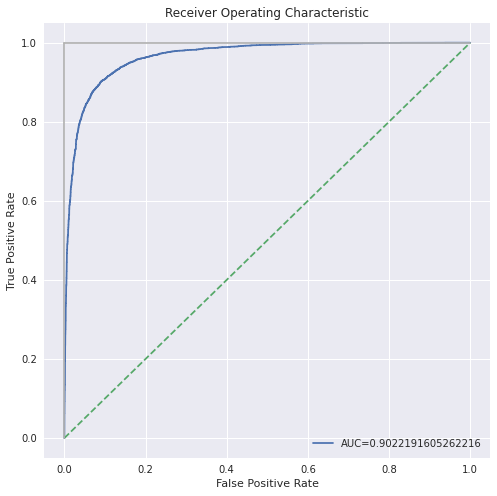

In [178]:
LR = 0.0045
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

It performed quite similarly.

Epoch 1
__________________________________
loss: 0.693482  [    0/28693]
loss: 0.671740  [21184/28693]
loss: 0.544667  [27136/28693]
loss: 0.533906  [47040/28693]
loss: 0.618663  [167680/28693]
loss: 0.374243  [52480/28693]
loss: 0.720511  [31872/28693]
loss: 0.415385  [122304/28693]
loss: 0.525340  [468480/28693]
loss: 0.445879  [91584/28693]
loss: 0.501539  [129280/28693]
loss: 0.262296  [145728/28693]
loss: 0.271136  [378624/28693]
loss: 0.251460  [132288/28693]
loss: 0.254684  [820736/28693]

Evaluation Results
_________________________________
Predicted 4166 / 5063 correctly
Mean Loss: 0.39 
Recall: 67.79%
Precision: 95.49%
Accuracy: 82.28%
Macro Averaged F1-score: 81.90%
_________________________________
Training loss:  0.4727257902058072  validation loss:  0.386894887160955  and accuracy:  82.28323128579893
__________________________________
Epoch 2
__________________________________
loss: 0.182494  [    0/28693]
loss: 0.150729  [11648/28693]
loss: 0.114300  [24320/28693]
loss: 

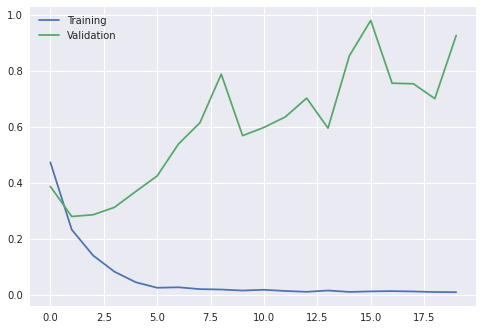

Best F1 score after  4  epochs.
Training Time: 13.44 minutes


In [181]:
LR = 0.0045
EPOCHS = 20
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

It is obvious that it overfits and than the early stopping helps the model and finally testing with the best model that was found.


Evaluation Results
_________________________________
Predicted 10144 / 11252 correctly
Mean Loss: 0.36 
Recall: 89.70%
Precision: 90.66%
Accuracy: 90.15%
Macro Averaged F1-score: 90.15%
_________________________________


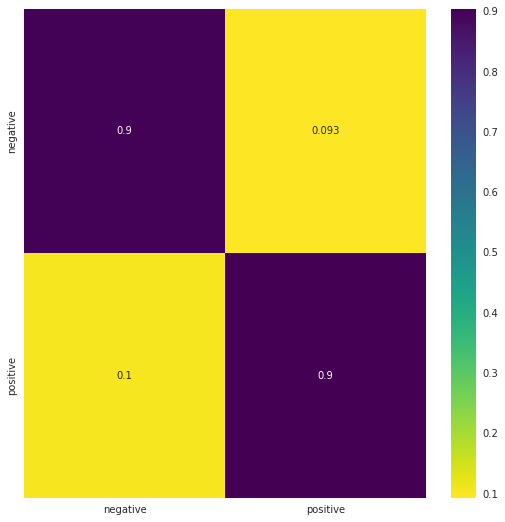

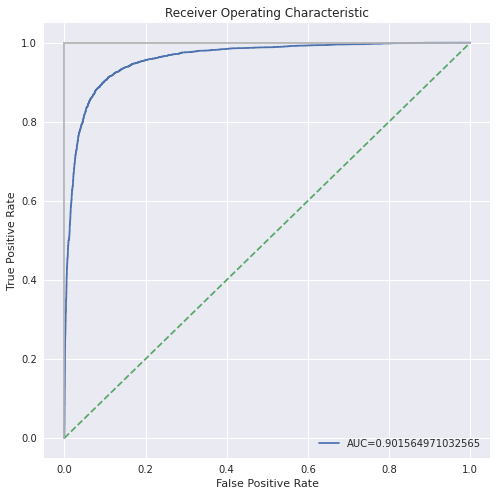

In [182]:
seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

### Layers Size

So trying to make sure with this bigger size it still is better with 2 layers I'll test initially with one layer.

Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 1.12 minutes

Evaluation Results
_________________________________
Predicted 10126 / 11252 correctly
Mean Loss: 0.31 
Recall: 91.54%
Precision: 88.93%
Accuracy: 89.99%
Macro Averaged F1-score: 89.99%
_________________________________


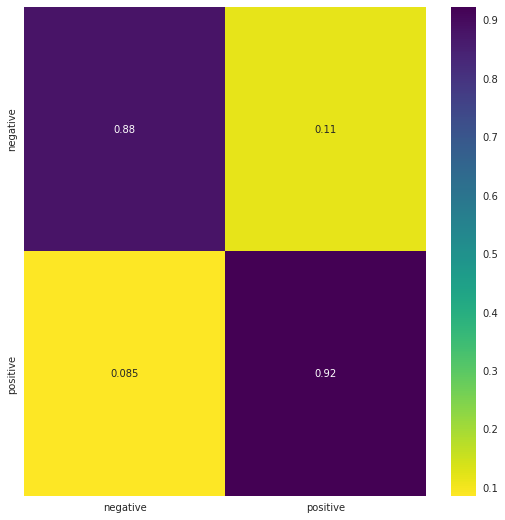

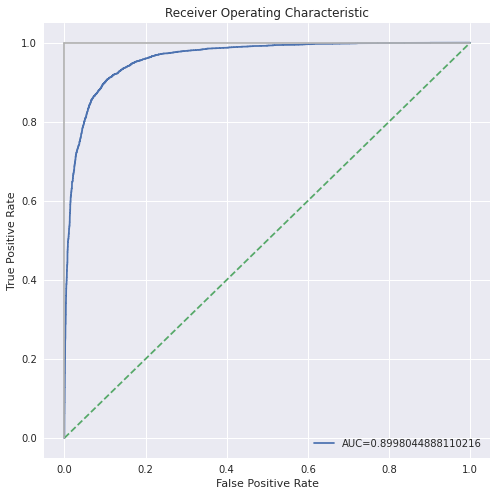

In [184]:
LR = 0.0045
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 1
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This peformed a bit off. Then trying with two layers.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 2.67 minutes

Evaluation Results
_________________________________
Predicted 10177 / 11252 correctly
Mean Loss: 0.41 
Recall: 90.27%
Precision: 90.73%
Accuracy: 90.45%
Macro Averaged F1-score: 90.45%
_________________________________


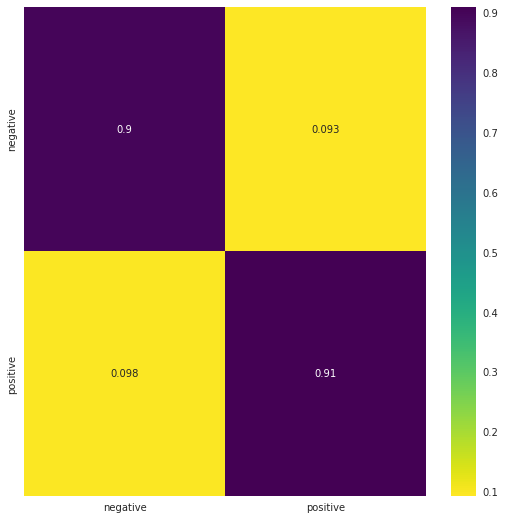

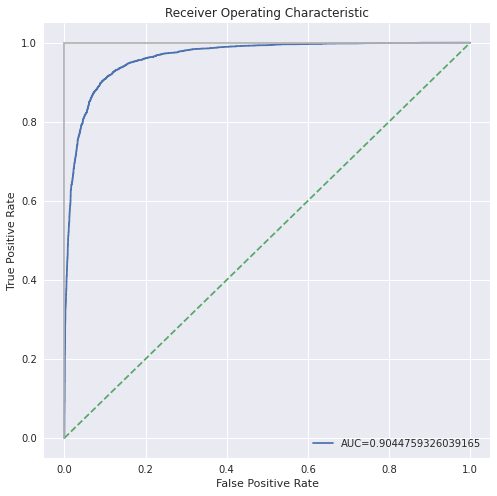

In [185]:
LR = 0.0045
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This performed better. Now increasing the layers to 3 and having three heads.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 3.90 minutes

Evaluation Results
_________________________________
Predicted 10136 / 11252 correctly
Mean Loss: 0.36 
Recall: 92.17%
Precision: 88.61%
Accuracy: 90.08%
Macro Averaged F1-score: 90.07%
_________________________________


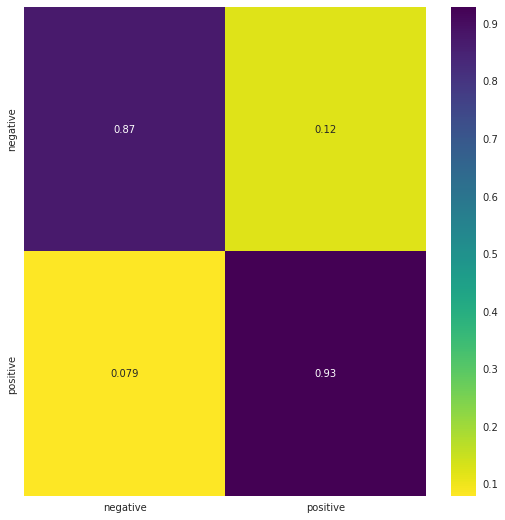

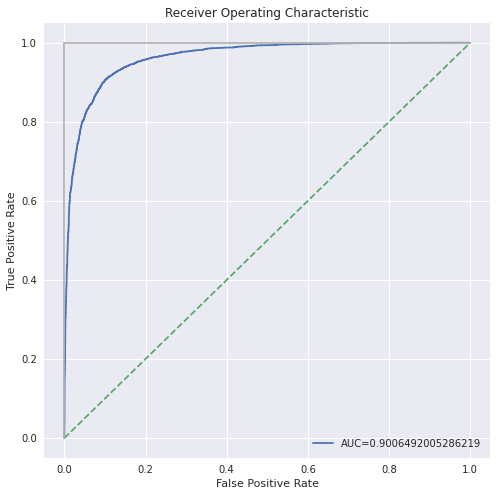

In [186]:
LR = 0.0045
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 3
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Then with four layers and three headed attention

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 5.09 minutes

Evaluation Results
_________________________________
Predicted 10163 / 11252 correctly
Mean Loss: 0.39 
Recall: 87.94%
Precision: 92.49%
Accuracy: 90.32%
Macro Averaged F1-score: 90.32%
_________________________________


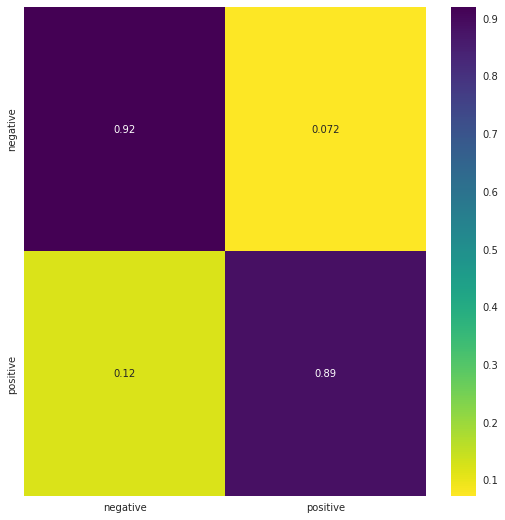

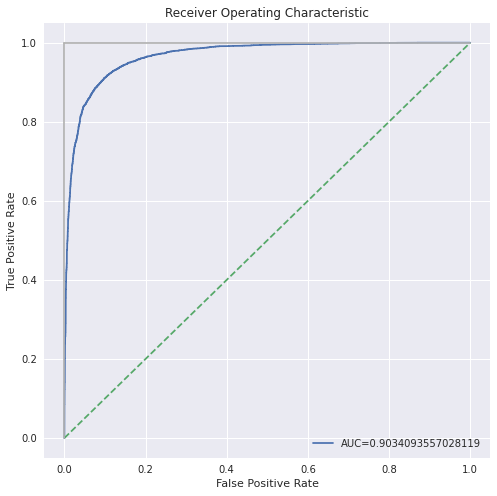

In [183]:
LR = 0.0045
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 4
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

There was minimal difference with the increased layer size and it took a lot of time. Again two layers seems to be the ideal middle ground.

### Gradient Clipping Values



I'll initially trial with values starting from zero.

Gradient clipping value:  0.0
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 3.64 minutes

Evaluation Results
_________________________________
Predicted 9797 / 11252 correctly
Mean Loss: 0.35 
Recall: 96.26%
Precision: 81.45%
Accuracy: 87.07%
Macro Averaged F1-score: 86.94%
_________________________________


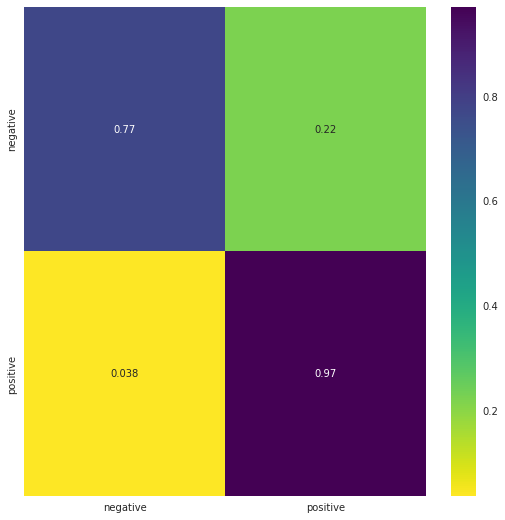

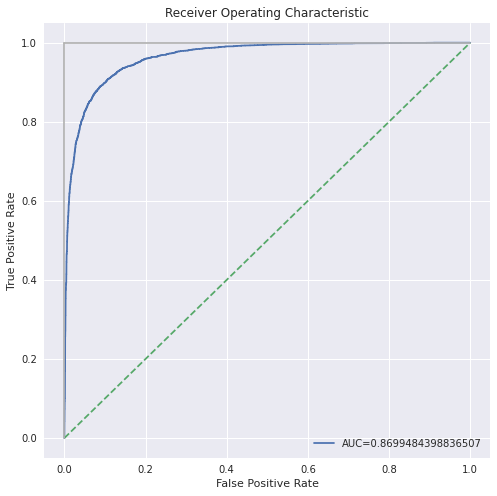

Gradient clipping value:  0.15
Early stopping on epoch:  2
Best F1 score after  2  epochs.
Training Time: 2.42 minutes

Evaluation Results
_________________________________
Predicted 10120 / 11252 correctly
Mean Loss: 0.27 
Recall: 95.34%
Precision: 86.17%
Accuracy: 89.94%
Macro Averaged F1-score: 89.90%
_________________________________


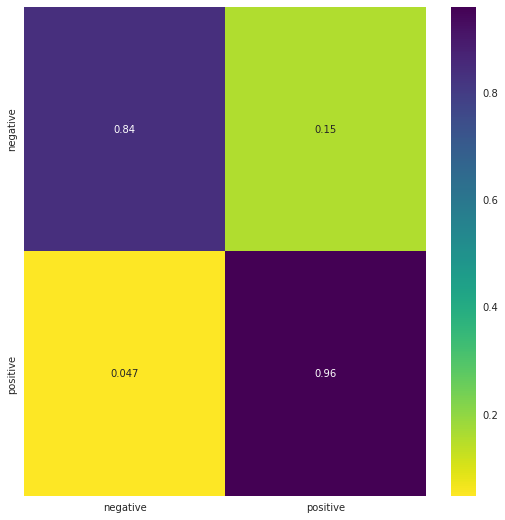

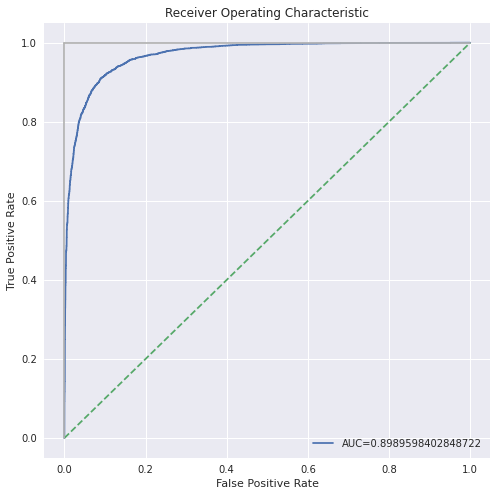

Gradient clipping value:  0.3
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 3.63 minutes

Evaluation Results
_________________________________
Predicted 10113 / 11252 correctly
Mean Loss: 0.34 
Recall: 94.80%
Precision: 86.43%
Accuracy: 89.88%
Macro Averaged F1-score: 89.84%
_________________________________


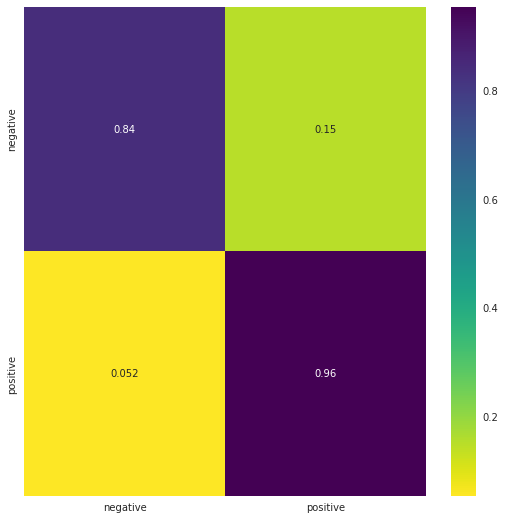

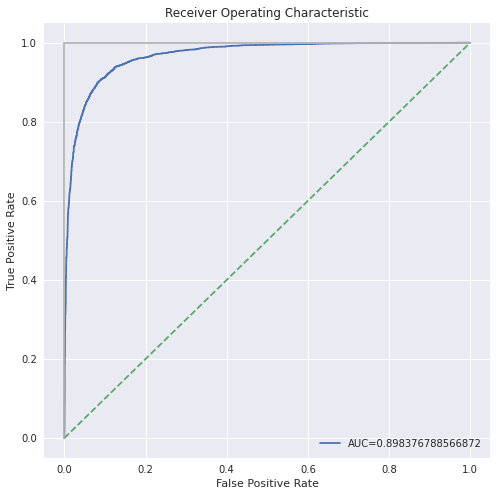

Gradient clipping value:  0.44999999999999996
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 3.63 minutes

Evaluation Results
_________________________________
Predicted 10037 / 11252 correctly
Mean Loss: 0.27 
Recall: 84.09%
Precision: 93.84%
Accuracy: 89.20%
Macro Averaged F1-score: 89.18%
_________________________________


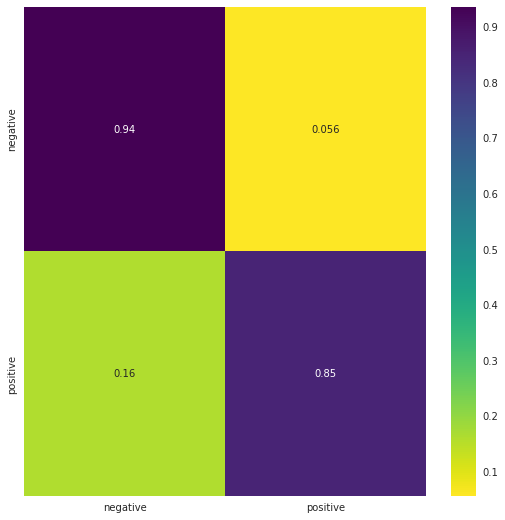

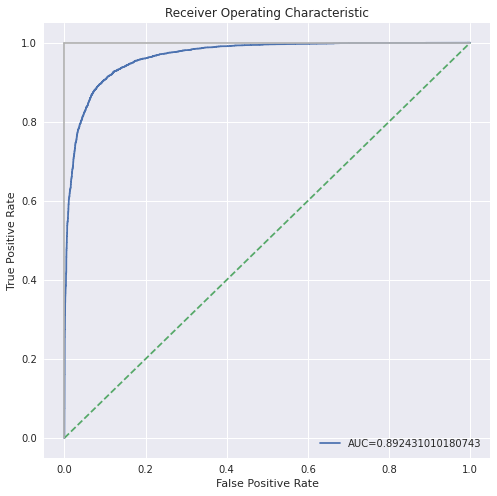

Gradient clipping value:  0.6
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 3.63 minutes

Evaluation Results
_________________________________
Predicted 10170 / 11252 correctly
Mean Loss: 0.31 
Recall: 88.27%
Precision: 92.31%
Accuracy: 90.38%
Macro Averaged F1-score: 90.38%
_________________________________


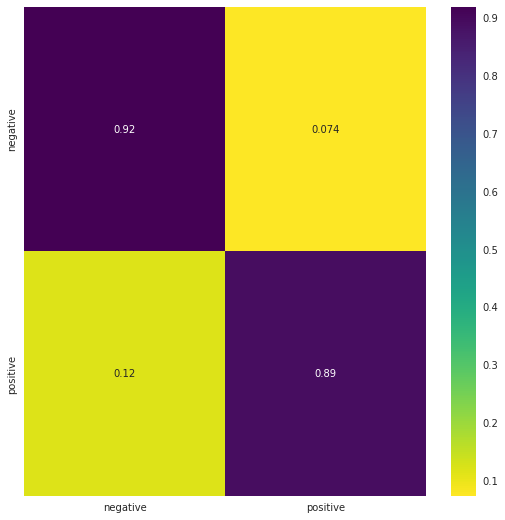

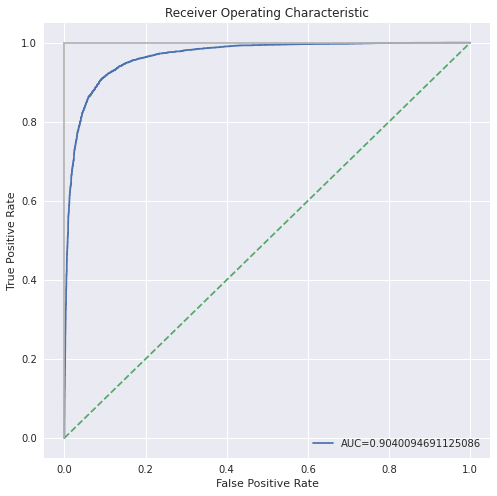

In [191]:
LR = 0.0047
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 4
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 1

for clip_value in np.arange(0, 0.65, 0.15):
    print("Gradient clipping value: ", clip_value)
    seedTorch()
    model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
    optimizer = torch.optim.Adam
    lossfunc = nn.CrossEntropyLoss()
    start_time = time.time()
    model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, clip_value)
    print("Best F1 score after ", bestEp, " epochs.")
    print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

    # Evaluate on the test set and print confusion matrix and roc curve
    trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
    confusionMatrix(trues, preds)
    roc_auc = rocCurve(trues, preds, probs)

This confirms the value I had set as the default. Then trialing with a few more values.

Gradient clipping value:  0.7
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 3.65 minutes

Evaluation Results
_________________________________
Predicted 10195 / 11252 correctly
Mean Loss: 0.25 
Recall: 91.59%
Precision: 89.95%
Accuracy: 90.61%
Macro Averaged F1-score: 90.60%
_________________________________


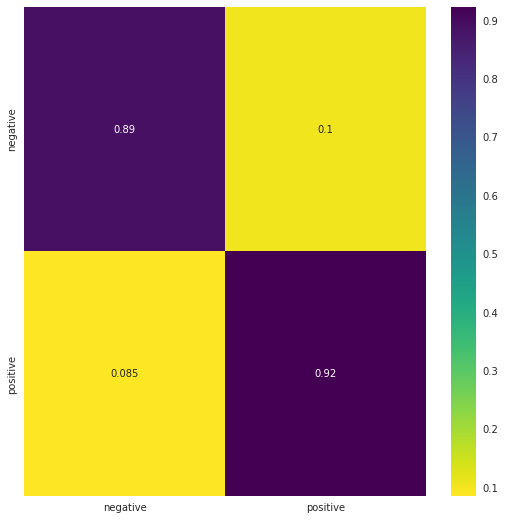

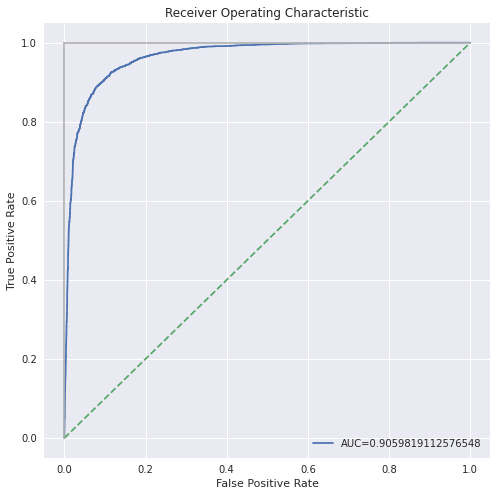

Gradient clipping value:  0.7999999999999999
Early stopping on epoch:  2
Best F1 score after  2  epochs.
Training Time: 2.42 minutes

Evaluation Results
_________________________________
Predicted 10163 / 11252 correctly
Mean Loss: 0.24 
Recall: 88.61%
Precision: 91.90%
Accuracy: 90.32%
Macro Averaged F1-score: 90.32%
_________________________________


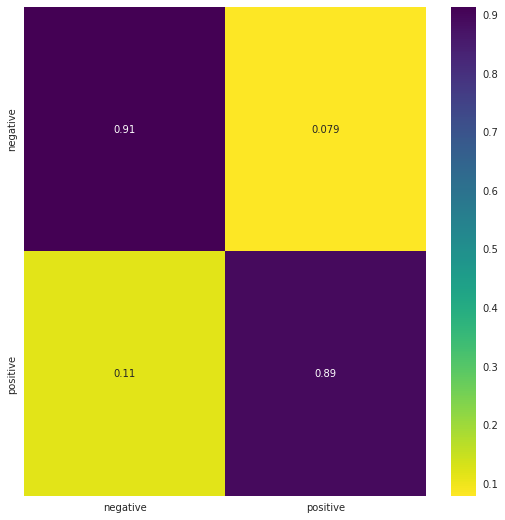

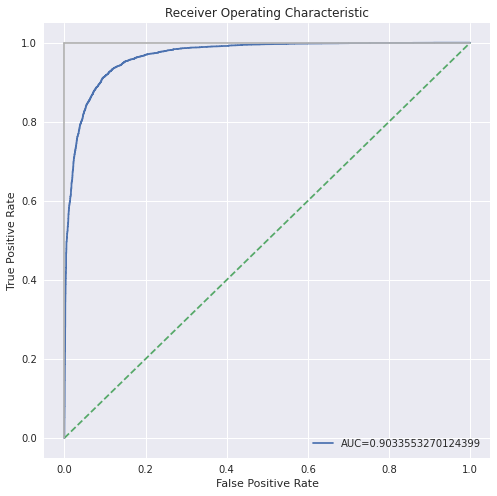

Gradient clipping value:  0.8999999999999999
Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 3.62 minutes

Evaluation Results
_________________________________
Predicted 10132 / 11252 correctly
Mean Loss: 0.31 
Recall: 85.80%
Precision: 93.92%
Accuracy: 90.05%
Macro Averaged F1-score: 90.03%
_________________________________


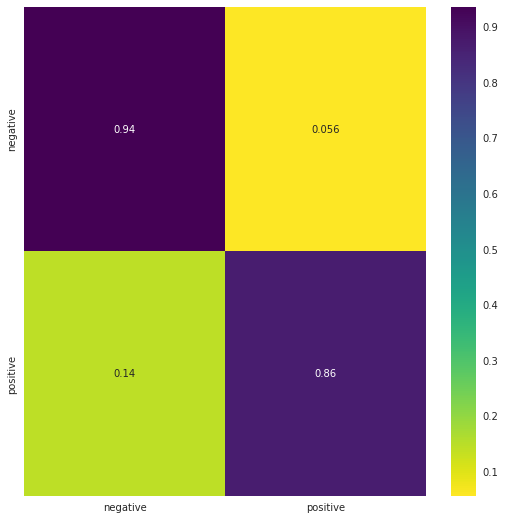

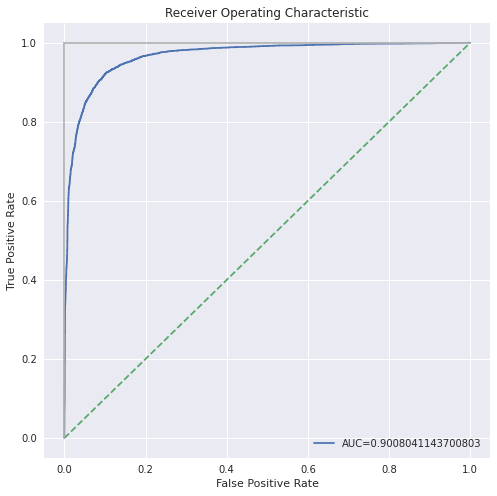

In [193]:
LR = 0.0047
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 4
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
PATIENCE = 1

for clip_value in np.arange(0.7, 0.9, 0.1):
    print("Gradient clipping value: ", clip_value)
    seedTorch()
    model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
    optimizer = torch.optim.Adam
    lossfunc = nn.CrossEntropyLoss()
    start_time = time.time()
    model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, clip_value)
    print("Best F1 score after ", bestEp, " epochs.")
    print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

    # Evaluate on the test set and print confusion matrix and roc curve
    trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
    confusionMatrix(trues, preds)
    roc_auc = rocCurve(trues, preds, probs)

So around 0.7 is the point of diminishing returns and then is getting worse. This shows me that this is a good value to experiment further in the next notebook that I finetune the network further.